# Imports

In [1]:
import sys
import os
import math

import time
import datetime as dt

import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations, combinations_with_replacement

import optuna
import pickle

# GPU properties

In [2]:
!nvidia-smi

Sun Mar 10 17:45:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.65                 Driver Version: 546.65       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0              11W /  65W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
torch.cuda.get_device_properties(torch.cuda)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=16)

In [4]:
# print(torch.cuda.memory_summary())

# Enable model differentiation by X

In [5]:
class diff_model_enable:
  def __init__(self, model, X):
    self.model = model
    self.X = X
  
  def __enter__(self):
    self.X.requires_grad = True
  
  def __exit__(self, exc_type, exc_val, exc_tb):
    self.X.requires_grad = False

In [6]:
def diff2(f, X):
  grads = torch.autograd.grad(
    outputs=f, inputs=X, grad_outputs=torch.ones_like(f),
    create_graph=True
  )[0]
  grad_grad = []
  for i in range(X.shape[1]):
    df = grads[:,i]
    df2 = torch.autograd.grad(
      outputs=df, inputs=X, grad_outputs=torch.ones_like(df),
      create_graph=True
    )[0][:,i]
    grad_grad.append(df2)
  return torch.stack(grad_grad, dim=1)

# Metropolis sampler

In [7]:
class MetropolisSampler():
  """Class for Metropolis sampler"""

  def __init__(self, dim1, dim2, epsilon=0.1, device='cpu'):
    self.epsilon = epsilon
    self.device = device
    self.sample = self.initialSample(dim1, dim2)

  def initialSample(self, dim1, dim2) -> torch.Tensor:
    return 3 * (
      torch.rand(
        (
          dim1, dim2
        )
      ) - 0.5
    ).to(self.device)
    
  def updateSampleBasOnDistrDens(self, __distributionDensity):
    newSample = self.sample + self.epsilon * (
      2 * torch.rand_like(
        self.sample,
        device=self.device
      ) - 1
    )
    critVal = __distributionDensity(newSample) / __distributionDensity(self.sample)
    doesPointMove = (torch.rand(len(self.sample), device=self.device) <= critVal)
    newSample = (
      torch.mul(doesPointMove.int(), newSample.t()).t()
      + torch.mul((1 - doesPointMove.int()), self.sample.t()).t()
    )
    self.sample = newSample

  def updateAndGetSample(self, __distributionDensity):
    for i in range(10):
      self.updateSampleBasOnDistrDens(__distributionDensity)
    return self.sample

# Integrate

In [8]:
def integrate(f, x: torch.Tensor, density) -> torch.Tensor:
  return torch.mean(f / density) #* torch.mean(density)

# Trial function

In [9]:
class TrialFunction(nn.Module):
  def __init__(self, dim_coord, num_states, potential, name,
               num_hidden_layers=3, num_hidden_neurons=60,
               init_mean_weights=0.0, init_std_weights=math.sqrt(0.1),
               activ_fnc=nn.Tanh()):
    super(TrialFunction, self).__init__()
    
    self.dim_coord = dim_coord
    self.num_states = num_states
    self.potential = potential

    self.name = name
    
    self.num_hidden_layers = num_hidden_layers
    self.num_hidden_neurons = num_hidden_neurons
    self.activ_fnc = activ_fnc
    # Layers
    self.layers = nn.Sequential()
    self.layers.append(nn.Linear(dim_coord, num_hidden_neurons))
    self.layers.append(activ_fnc)
    for layer in range(num_hidden_layers-1):
      self.layers.append(nn.Linear(num_hidden_neurons, num_hidden_neurons))
      self.layers.append(activ_fnc)
    # Gaussian weights
    self.gaussian_weights = nn.Linear(dim_coord, num_hidden_neurons, bias=False)
    # Out layer
    self.out_layer = nn.ModuleList(
      [nn.Linear(num_hidden_neurons, 1, bias=False) for state in range(num_states)]
    )
    # Initialise weigths
    self.init_weights(init_mean_weights, init_std_weights)

  def init_weights(self, init_mean_weights, init_std_weights):
    for layer in range(len(self.layers)):
      if 'weight' in dir(self.layers[layer]):
        nn.init.normal_(self.layers[layer].weight, init_mean_weights, init_std_weights)
      if 'bias' in dir(self.layers[layer]):
        nn.init.normal_(self.layers[layer].bias, init_mean_weights, init_std_weights)

    nn.init.normal_(self.gaussian_weights.weight, init_mean_weights, init_std_weights)
    # nn.init.sparse_(self.gaussian_weights.weight, sparsity=0.9, std=1)

    for layer in range(len(self.out_layer)):
      if 'weight' in dir(self.out_layer[layer]):
        nn.init.normal_(
          self.out_layer[layer].weight, 
          1.0/math.sqrt(self.num_hidden_neurons), #init_mean_weights, 
          0.01 #init_std_weights
        )

  def forward(self, x):
    z = self.layers(x)
    
    sqr_gauss_weights = self.gaussian_weights.weight*self.gaussian_weights.weight
    gauss_kernel = torch.exp(-torch.matmul(x*x, torch.transpose(sqr_gauss_weights, 0, 1)))

    z_prime = gauss_kernel * z
    return [psi_n(z_prime) for psi_n in self.out_layer]

  def weigth_function(self, x):
    forward_ = self.forward(x)
    result = torch.zeros(len(x)).to(x.device)
    for psi_n in forward_:
      result += psi_n.squeeze(1) ** 2
    result /= len(forward_)
    return result #/ sum(result)

# Conditions and losses

In [10]:
def cache_psi(cache_dict):
  def wrapped(func):
    id_val = cache_dict
    def inner(*args):
      curr = id(args[0])
      if curr not in id_val:
        id_val[curr] = func(*args)
      return id_val[curr]
    return inner
  return wrapped  

CacheHamilt = dict()
@cache_psi(CacheHamilt)
def Hamiltonian(psi, x, potential):
  return (
    -0.5 * torch.sum(diff2(psi, x), dim=1).unsqueeze(1)
    + (potential(x) * psi.squeeze(1)).unsqueeze(1)
  )

CacheRayleigh = dict()
@cache_psi(CacheRayleigh)
def Rayleigh(psi, x, potential, density):
  return (
    integrate(psi*Hamiltonian(psi, x, potential), x, density)
    / integrate(psi*psi, x, density)
  )

def SqrResidual(output, x, potential, density):
  return sum(
    integrate((Hamiltonian(psi, x, potential) - Rayleigh(psi, x, potential, density)*psi)**2, x, density)
    / integrate(psi*psi, x, density) for psi in output
  )

def SqrResidualForPsi(psi, x, potential, density):
  return (
    integrate((Hamiltonian(psi, x, potential) - Rayleigh(psi, x, potential)*psi)**2, x, density)
    / integrate(psi*psi, x, density)
  ) 

def NormCond(trial_fnc):
  return sum((torch.sum(A*A, dim=1) - 1)**2 for A in trial_fnc.out_layer.parameters())

def OrthogonCond(output, x, density):
  result = []
  for psi_n, psi_m in combinations(output, 2):
    result += [(
      torch.square(integrate(psi_n*psi_m, x, density)) 
      / integrate(psi_n*psi_n, x, density) 
      / integrate(psi_m*psi_m, x, density)
    )]
  return sum(result)

def BoundCond(model, x):
  x1 = torch.zeros_like(x)
  x1[:,3:] = x[:,3:]

  x2 = torch.zeros_like(x)
  x2[:,:3] = x[:,:3]

  # x3 = torch.ones_like(x) * x
  # x3[:,3:] = x3[:,:3]

  # https://en.wikipedia.org/wiki/N-sphere
  R = 40
  a = torch.rand_like(x[:,:-1])
  a[:,0] = a[:,0] * 2 * torch.pi
  a[:,1:] = a[:,1:] * torch.pi - torch.pi / 2
  x4 = torch.ones_like(x)
  x4[:,0] = R * torch.cos(a[:,0]) * torch.cos(a[:,1]) * torch.cos(a[:,2]) * torch.cos(a[:,3]) * torch.cos(a[:,4])
  x4[:,1] = R * torch.sin(a[:,0]) * torch.cos(a[:,1]) * torch.cos(a[:,2]) * torch.cos(a[:,3]) * torch.cos(a[:,4])
  x4[:,2] = R * torch.sin(a[:,1]) * torch.cos(a[:,2]) * torch.cos(a[:,3]) * torch.cos(a[:,4])
  x4[:,3] = R * torch.sin(a[:,2]) * torch.cos(a[:,3]) * torch.cos(a[:,4])
  x4[:,4] = R * torch.sin(a[:,3]) * torch.cos(a[:,4])
  x4[:,5] = R * torch.cos(a[:,4])
    
  return torch.sum(
    torch.stack(model(x1), dim=0)**2
    + torch.stack(model(x2), dim=0)**2
    # + torch.stack(model(x3), dim=0)**2
    + torch.stack(model(x4), dim=0)**2
  )

# Show state

In [11]:
def show_state(model, state, S):
  sampler = MetropolisSampler(
    dim1=S, 
    dim2=model.dim_coord,
    epsilon=0.1, 
    device=device
  )
  x = sampler.updateAndGetSample(model.weigth_function)

  dims = list(range(model.dim_coord))
  fig = plt.figure(dpi=300, layout='constrained')

  xmax = torch.max(x).detach().cpu()
  xmin = torch.min(x).detach().cpu()

  for dim1, dim2 in combinations_with_replacement(dims, 2):
    ax = fig.add_subplot(
      model.dim_coord, model.dim_coord, 1+dim1*model.dim_coord+dim2,
      aspect='equal'
    )
    ax.tick_params(axis='both', which='major', labelsize=3)
    ax.tick_params(axis='both', which='minor', labelsize=3)
    ax.tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(0.5)
    if dim1 == dim2:
      x1 = torch.sort(x[:,dim1])[0]
      
      xx = torch.zeros_like(x)
      xx[:,dim1] = x1.to(device)
      
      yy = model(x)[state]
      yy = yy / torch.max(abs(yy))
      
      ax.plot(
        x1.detach().cpu(),
        yy.detach().cpu(),
        linewidth=0.5
      )
      ax.set_xlim(xmin,xmax)
    else:      
      xx = torch.zeros_like(x)
      xx[:,[dim1,dim2]] = x[:,[dim1,dim2]]
      
      yy = model(x)[state]
      yy = yy / torch.max(abs(yy))

      ax.tricontourf(
        xx[:,dim1].detach().cpu(),
        xx[:,dim2].detach().cpu(),
        yy.squeeze(1).detach().cpu(), 
        levels=np.linspace(-1,1,14), 
        cmap="RdBu_r"
      )
      ax.set_xlim(xmin,xmax)
      ax.set_ylim(xmin,xmax)
  return fig

# Checkpoint

In [12]:
def save_checkpoint(model, optimizer, step, loss):
  checkpoint = {
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'step' : step,
    'loss' : loss
  }
  fn = f"checkpoints/{model.name}.pt"
  torch.save(checkpoint, fn)

# Helium atom, test

In [24]:
dim_coord = 6
num_states = 3
potential = lambda x: (
  -2/torch.sqrt(torch.sum(x[:,:3]**2, dim=1))
  -2/torch.sqrt(torch.sum(x[:,3:]**2, dim=1))
  +1/torch.sqrt(torch.sum((x[:,:3]-x[:,3:])**2, dim=1))
)
num_hidden_layers = 3
num_hidden_neurons = 150
init_mean_weights = 0.0
init_std_weights = math.sqrt(0.1)
activ_fnc = nn.Tanh()

alpha = 2 #1e2
beta = 1
gamma = 1e3
delta = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
S = 2000
sampler = MetropolisSampler(dim1=S, dim2=dim_coord, epsilon=0.1, device=device)

lr = 1e-3
weight_decay = 5e-4

CHECKPOINT_PERIOD = 100

MAX_SQR_RESIDUAL = 1e-6

load_checkpoint = True #False

name = "test_He_1"

In [25]:
START_TIME = time.time()
  
hist = {
  'time' : list(),
  'loss' : list(),
  'sqr res' : list(),
  'norm cond' : list(),
  'orthogon cond' : list(),
  'bound cond' : list(),
}
for state in range(num_states):
  hist[f"Rayleigh{state}"] = list()
for state in range(num_states):
  hist[f"sqr_res_per_state{state}"] = list()

model = TrialFunction(dim_coord, num_states, potential, name,
               num_hidden_layers, num_hidden_neurons,
               init_mean_weights, init_std_weights,
               activ_fnc).to(device)

optimizer = torch.optim.AdamW(
  params=list(model.parameters()),
  lr=lr,
  weight_decay=weight_decay
)

# loss_weight = nn.Linear(1,4,bias=False).to(device)
# nn.init.ones_(loss_weight.weight)

# optimizer_loss_weight = torch.optim.AdamW(
#   params=list(loss_weight.parameters()),
#   lr=1e2,#lr,
#   maximize=True
# )

if load_checkpoint:
  checkpoint = torch.load(f"checkpoints/{model.name}.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  model.train()
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  step = checkpoint['step']
  loss = checkpoint['loss']
  print(f"Load model and optimizer: step {checkpoint['step']}, loss {checkpoint['loss']}")
  # history
  hist_df = pd.read_csv(f"history/{model.name}.csv")
  hist['time'] = hist_df['time'].to_list()
  hist['loss'] = hist_df['loss'].to_list()
  hist['sqr res'] = hist_df['sqr res'].to_list()
  hist['norm cond'] = hist_df['norm cond'].to_list()
  hist['orthogon cond'] = hist_df['orthogon cond'].to_list()
  hist['bound cond'] = hist_df['bound cond'].to_list()
  for state in range(num_states):
    hist[f"Rayleigh{state}"] = hist_df[f"Rayleigh{state}"].to_list()
  for state in range(num_states):
    hist[f"sqr_res_per_state{state}"] = hist_df[f"sqr_res_per_state{state}"].to_list()

x = sampler.updateAndGetSample(model.weigth_function)
step = 0

valid_states = 0
while (valid_states < num_states):
  step += 1
  x = sampler.updateAndGetSample(model.weigth_function)

  # alpha = loss_weight.weight[0] 
  # beta = loss_weight.weight[1]
  # gamma = loss_weight.weight[2]
  # delta = loss_weight.weight[3]

  with diff_model_enable(model, x):
    output = model(x)
    density = model.weigth_function(x)
    
    sqr_residual = SqrResidual(output, x, potential, density)
    
    energies = [Rayleigh(psi, x, potential, density) for psi in output]
    energ_cond = sum(energies)
    
    norm_cond = NormCond(model)
    
    orthogon_cond = OrthogonCond(output, x, density)

    bound_cond = BoundCond(model, x)
    
    loss = (
      sqr_residual 
      + alpha * energ_cond 
      + beta * norm_cond 
      + gamma * orthogon_cond
      + delta * bound_cond
    )

    if torch.isnan(loss):
      print('Loss is NaN!')
      # print('')
      # print(list(loss_weight.parameters()))
      print('')
      print(list(model.parameters()))
      sys.exit(-1)
    
    sqr_res_per_state = [SqrResidualForPsi(psi, x, potential, density) for psi in output]
    valid_states = sum(sqr_res_per_state_ < MAX_SQR_RESIDUAL for sqr_res_per_state_ in sqr_res_per_state)

  optimizer.zero_grad()
  # optimizer_loss_weight.zero_grad()
  loss.backward()
  optimizer.step()
  # optimizer_loss_weight.step()

  # for w in loss_weight.parameters():
  #   w.data.clamp_(0.01, 100.0)
  
  CacheRayleigh.clear()
  CacheHamilt.clear()

  hist['time'] += [time.time() - START_TIME]
  hist['loss'] += [loss.item()]
  hist['sqr res'] += [sqr_residual.item()]
  hist['norm cond'] += [norm_cond.item()]
  hist['orthogon cond'] += [orthogon_cond.item()]
  hist['bound cond'] += [bound_cond.item()]
  for state in range(num_states):
    hist[f"Rayleigh{state}"] += [energies[state].item()]
    hist[f"sqr_res_per_state{state}"] += [sqr_res_per_state[state].item()]

  if step == 1:
    header = (
        "step, time, loss, sqr res,"
        + " norm cond, orthogon cond, bound cond"
    )
    for i in range(num_states):
      header += f", Rayleigh{i}"
    for i in range(num_states):
      header += f", sqr_res_per_state{i}"
    print(header)
  
  if (step % CHECKPOINT_PERIOD) == 0 or step == 1:            
    info = (
      f"{step}, "
      + f"{time.time() - START_TIME:.2f}, "
      + f"{loss.item():.2e}, "
      + f"{sqr_residual.item():.2e}, "
      + f"{norm_cond.item():.2e}, "
      + f"{orthogon_cond.item():.2e}, "
      + f"{bound_cond.item():.2e}"
    )
    for Rayleigh_ in energies:
      info += f", {Rayleigh_.item():.2e}"
    for sqr_res_per_state_ in sqr_res_per_state:
      info += f", {sqr_res_per_state_.item():.2e}"
    print(info)

    # print(f"alpha {alpha.item():.4f}, beta {beta.item():.4f}, gamma {gamma.item():.4f}, delta {delta.item():.4f}")
      
    hist_df = pd.DataFrame(data=hist)
    hist_df.to_csv(f"history/{model.name}.csv")

    save_checkpoint(model, optimizer, step, loss)

Load model and optimizer: step 4000, loss tensor([-780.4046], device='cuda:0', requires_grad=True)
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.61, 6.74e+02, 1.47e+01, 2.92e+00, 6.33e-01, 3.59e+01, -2.52e+00, -2.04e+00, -1.90e+00, 2.71e+00, 6.52e+00, 5.50e+00
100, 14.34, 3.77e+01, 1.41e+01, 2.83e+00, 1.75e-03, 2.69e+01, -1.06e+00, -1.38e+00, -1.51e+00, 7.13e+00, 3.11e+00, 3.88e+00
200, 28.23, 1.14e+01, 4.90e+00, 2.85e+00, 1.95e-03, 8.07e+00, -5.65e-01, -1.25e+00, -1.36e+00, 2.04e+00, 1.21e+00, 1.64e+00
300, 41.69, 8.82e+00, 5.61e+00, 2.85e+00, 1.41e-03, 4.97e+00, -5.36e-01, -1.14e+00, -1.34e+00, 2.75e+00, 1.24e+00, 1.61e+00
400, 54.65, 5.22e+00, 4.25e+00, 2.86e+00, 9.83e-04, 3.67e+00, -8.72e-01, -1.16e+00, -1.24e+00, 1.70e+00, 1.11e+00, 1.44e+00
500, 68.02, 6.62e+00, 4.78e+00, 2.86e+00, 2.67e-03, 2.99e+00, -8.32e-01, -1.21e+00, -1.30e+00, 2.27e+00, 1.13e+00, 1.38e+00
600

KeyboardInterrupt: 

# Helium atom, 3 states

In [16]:
def objective(trial):
  dim_coord = 6
  num_states = 3
  potential = lambda x: (
    -2/torch.sqrt(torch.sum(x[:,:3]**2, dim=1))
    -2/torch.sqrt(torch.sum(x[:,3:]**2, dim=1))
    +1/torch.sqrt(torch.sum((x[:,:3]-x[:,3:])**2, dim=1))
  )
  
  num_hidden_layers = 3
  num_hidden_neurons = trial.suggest_int("num_hidden_neurons", 36, 300)
  init_mean_weights = 0.0
  init_std_weights = math.sqrt(0.1)
  activ_fnc = nn.Tanh()

  alpha = trial.suggest_float("alpha", 1, 1e3, log=True)
  beta = trial.suggest_float("beta", 1, 1e3, log=True)
  gamma = trial.suggest_float("gamma", 1, 1e3, log=True)
  delta = trial.suggest_float("delta", 1, 1e3, log=True)
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  
  S = 2000
  sampler = MetropolisSampler(dim1=S, dim2=dim_coord, epsilon=0.1, device=device)

  lr = 1e-3
  weight_decay = 5e-4

  name = f"test_He_{trial.number}"

  print(f"Name: {name}, num_hidden_neurons: {num_hidden_neurons}, alpha: {alpha:.4e}, beta: {beta:.4e}, gamma: {gamma:.4e}, delta: {delta:.4e}")

  START_TIME = time.time()
    
  hist = {
    'time' : list(),
    'loss' : list(),
    'sqr res' : list(),
    'norm cond' : list(),
    'orthogon cond' : list(),
    'bound cond' : list(),
  }
  for state in range(num_states):
    hist[f"Rayleigh{state}"] = list()
  for state in range(num_states):
    hist[f"sqr_res_per_state{state}"] = list()
    
  model = TrialFunction(dim_coord, num_states, potential, name,
                 num_hidden_layers, num_hidden_neurons,
                 init_mean_weights, init_std_weights,
                 activ_fnc).to(device)
  
  optimizer = torch.optim.AdamW(
    params=list(model.parameters()),
    lr=lr,
    weight_decay=weight_decay
  )
  
  x = sampler.updateAndGetSample(model.weigth_function)
  
  step = 0
  while (time.time() - START_TIME < TIMEOUT):
    step += 1
    x = sampler.updateAndGetSample(model.weigth_function)
  
    with diff_model_enable(model, x):
      output = model(x)
      density = model.weigth_function(x)
      
      sqr_residual = SqrResidual(output, x, potential, density)
      
      energies = [Rayleigh(psi, x, potential, density) for psi in output]
      energ_cond = sum(energies)
      
      norm_cond = NormCond(model)
      
      orthogon_cond = OrthogonCond(output, x, density)
  
      bound_cond = BoundCond(model, x)
      
      loss = (
        sqr_residual 
        + alpha * energ_cond 
        + beta * norm_cond 
        + gamma * orthogon_cond
        + delta * bound_cond
      )
  
      if torch.isnan(loss):
        print('Loss is NaN!')
        print('Parameters:',list(model.parameters()))
        raise optuna.exceptions.TrialPruned()
      
      sqr_res_per_state = [SqrResidualForPsi(psi, x, potential, density) for psi in output]
  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    CacheRayleigh.clear()
    CacheHamilt.clear()

    # objective_output
    objective_output = sqr_residual.item() + energ_cond.item()
  
    hist['time'] += [time.time() - START_TIME]
    hist['loss'] += [loss.item()]
    hist['sqr res'] += [sqr_residual.item()]
    hist['norm cond'] += [norm_cond.item()]
    hist['orthogon cond'] += [orthogon_cond.item()]
    hist['bound cond'] += [bound_cond.item()]
    for state in range(num_states):
      hist[f"Rayleigh{state}"] += [energies[state].item()]
      hist[f"sqr_res_per_state{state}"] += [sqr_res_per_state[state].item()]
  
    if step == 1:
      header = (
          "step, time, loss, sqr res,"
          + " norm cond, orthogon cond, bound cond"
      )
      for i in range(num_states):
        header += f", Rayleigh{i}"
      for i in range(num_states):
        header += f", sqr_res_per_state{i}"
      print(header)
    
    if (step % CHECKPOINT_PERIOD) == 0 or step == 1:            
      info = (
        f"{step}, "
        + f"{time.time() - START_TIME:.2f}, "
        + f"{loss.item():.2e}, "
        + f"{sqr_residual.item():.2e}, "
        + f"{norm_cond.item():.2e}, "
        + f"{orthogon_cond.item():.2e}, "
        + f"{bound_cond.item():.2e}"
      )
      for Rayleigh_ in energies:
        info += f", {Rayleigh_.item():.2e}"
      for sqr_res_per_state_ in sqr_res_per_state:
        info += f", {sqr_res_per_state_.item():.2e}"
      print(info)
      
      hist_df = pd.DataFrame(data=hist)
      hist_df.to_csv(f"history/{model.name}.csv")
  
      save_checkpoint(model, optimizer, step, loss)

    if (step % PRUNER_PERIOD == 0):
      trial.report(objective_output, step)
      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
  
  return objective_output

In [24]:
optuna.delete_study(study_name=study_name, storage=storage_name)

In [25]:
CHECKPOINT_PERIOD = 100
PRUNER_PERIOD = 5000
TIMEOUT = 30 * 60 # seconds

In [ ]:
study_name = "helium-3states-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
sampler_name = f"sampler_{study_name}.pkl"

# restored_sampler = pickle.load(open(sampler_name, "rb"))

study = optuna.create_study(
  pruner=optuna.pruners.MedianPruner(n_min_trials=5),
  study_name=study_name, storage=storage_name,
  load_if_exists=True, 
  # sampler=restored_sampler
)

study.optimize(
  objective, n_trials=100,
)

# save sampler state
with open(sampler_name, "wb") as fout:
  pickle.dump(study.sampler, fout)


[I 2024-03-10 18:07:34,568] A new study created in RDB with name: helium-3states-study


Name: test_He_0, num_hidden_neurons: 259, alpha: 4.8677e+01, beta: 1.6083e+00, gamma: 5.8030e+01, delta: 3.4551e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.44, 5.76e+04, 1.40e+02, 4.12e-03, 2.93e+00, 1.66e+04, 6.37e-01, 7.57e-01, 1.11e+00, 4.37e+01, 4.41e+01, 5.17e+01
100, 17.18, 5.52e+02, 3.93e+01, 3.88e-02, 2.98e+00, 7.61e+01, 5.01e-01, 5.57e-01, 5.11e-01, 1.29e+01, 1.32e+01, 1.33e+01
200, 33.93, 3.37e+02, 1.56e+01, 5.91e-02, 2.99e+00, 3.96e+01, 7.08e-02, 9.88e-02, 5.94e-02, 5.23e+00, 5.21e+00, 5.16e+00
300, 50.94, 2.49e+02, 1.06e+01, 7.77e-02, 2.99e+00, 2.98e+01, -2.61e-01, -2.68e-01, -2.62e-01, 3.40e+00, 3.67e+00, 3.51e+00
400, 67.87, 2.14e+02, 9.32e+00, 9.45e-02, 3.00e+00, 2.02e+01, -2.60e-01, -2.73e-01, -2.77e-01, 3.16e+00, 3.09e+00, 3.07e+00
500, 85.05, 1.71e+02, 5.82e+00, 1.10e-01, 3.00e+00, 1.64e+01, -4.52e-01, -4.45e-01, -4.50e-01, 1.93e+00, 1.94e+00, 1.95

[I 2024-03-10 18:35:38,577] Trial 0 pruned. 


Loss is NaN!
Parameters: [Parameter containing:
tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

[I 2024-03-10 19:05:38,907] Trial 1 finished with value: 6.402556896209717 and parameters: {'num_hidden_neurons': 270, 'alpha': 32.95521247606473, 'beta': 300.66652742039184, 'gamma': 58.78207462826421, 'delta': 4.878878667543364}. Best is trial 1 with value: 6.402556896209717.


Name: test_He_2, num_hidden_neurons: 172, alpha: 1.0894e+01, beta: 1.0561e+01, gamma: 5.0369e+02, delta: 1.0908e+01
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.19, 7.21e+04, 9.64e+01, 2.96e-03, 2.92e+00, 6.46e+03, 1.35e+00, 1.25e+00, 8.93e-01, 3.37e+01, 3.30e+01, 2.97e+01
100, 14.47, 2.17e+03, 4.94e+01, 4.09e-02, 2.95e+00, 5.24e+01, 2.05e+00, 2.02e+00, 2.00e+00, 1.66e+01, 1.65e+01, 1.63e+01
200, 29.00, 1.86e+03, 3.46e+01, 6.46e-02, 2.92e+00, 2.76e+01, 1.47e+00, 1.45e+00, 1.40e+00, 1.18e+01, 1.13e+01, 1.15e+01
300, 43.48, 1.68e+03, 2.99e+01, 8.54e-02, 2.76e+00, 1.99e+01, 1.39e+00, 1.42e+00, 1.28e+00, 9.89e+00, 9.78e+00, 1.03e+01
400, 58.11, 7.61e+02, 3.04e+01, 1.06e-01, 7.94e-01, 2.68e+01, 1.81e+00, 8.98e-01, 7.06e-01, 1.20e+01, 9.17e+00, 9.14e+00
500, 72.10, 3.43e+02, 4.38e+01, 1.41e-01, 5.41e-02, 2.18e+01, 1.36e+00, 8.46e-01, 8.13e-01, 1.93e+01, 1.19e+01, 1.26e+01
600,

[I 2024-03-10 19:30:25,650] Trial 2 pruned. 


Loss is NaN!
Parameters: [Parameter containing:
tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

[I 2024-03-10 19:57:49,557] Trial 3 pruned. 


Loss is NaN!
Parameters: [Parameter containing:
tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

[I 2024-03-10 20:17:37,170] Trial 4 pruned. 


Loss is NaN!
Parameters: [Parameter containing:
tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

[I 2024-03-10 20:47:37,405] Trial 5 finished with value: -1.5560722351074219 and parameters: {'num_hidden_neurons': 183, 'alpha': 5.988925019257158, 'beta': 297.449338883218, 'gamma': 11.39605810266237, 'delta': 7.039340554650032}. Best is trial 5 with value: -1.5560722351074219.


Name: test_He_6, num_hidden_neurons: 199, alpha: 9.8261e+02, beta: 1.7725e+00, gamma: 9.6984e+00, delta: 8.0173e+01
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.19, 4.27e+05, 1.11e+02, 1.27e-03, 2.89e+00, 5.26e+03, 1.65e+00, 1.57e+00, 1.97e+00, 3.68e+01, 3.39e+01, 3.98e+01
100, 14.90, 5.53e+03, 2.61e+01, 7.50e-02, 2.98e+00, 4.64e+01, 5.86e-01, 6.00e-01, 5.97e-01, 8.59e+00, 8.82e+00, 8.67e+00
200, 30.23, 1.42e+03, 1.04e+01, 1.25e-01, 2.99e+00, 2.36e+01, -1.65e-01, -1.84e-01, -1.76e-01, 3.50e+00, 3.42e+00, 3.50e+00
300, 45.27, 4.61e+01, 6.61e+00, 1.69e-01, 3.00e+00, 1.33e+01, -3.57e-01, -3.61e-01, -3.53e-01, 2.19e+00, 2.21e+00, 2.21e+00
400, 60.52, -7.60e+02, 4.06e+00, 2.08e-01, 3.00e+00, 1.11e+01, -5.70e-01, -5.72e-01, -5.70e-01, 1.37e+00, 1.35e+00, 1.35e+00
500, 75.88, -8.10e+02, 2.92e+00, 2.46e-01, 3.00e+00, 7.39e+00, -4.85e-01, -4.87e-01, -4.88e-01, 9.75e-01, 9.62e-01,

[I 2024-03-10 21:17:37,496] Trial 6 finished with value: 0.08696746826171875 and parameters: {'num_hidden_neurons': 199, 'alpha': 982.6062825801505, 'beta': 1.7724794155476626, 'gamma': 9.698421854170673, 'delta': 80.17258663185639}. Best is trial 5 with value: -1.5560722351074219.


Name: test_He_7, num_hidden_neurons: 68, alpha: 5.4872e+02, beta: 4.5181e+02, gamma: 4.8884e+01, delta: 3.2473e+02
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.29, 9.53e+05, 1.74e+01, 1.35e-03, 2.95e+00, 2.94e+03, -3.83e-01, -4.68e-01, -4.89e-01, 5.85e+00, 5.74e+00, 5.86e+00
100, 25.65, 1.33e+04, 6.21e+00, 4.61e-02, 2.99e+00, 3.90e+01, 2.92e-01, 2.75e-01, 2.78e-01, 2.11e+00, 2.04e+00, 2.06e+00
200, 51.20, 6.46e+03, 3.49e+00, 7.16e-02, 2.99e+00, 1.91e+01, 5.43e-02, 4.07e-02, 4.50e-02, 1.18e+00, 1.16e+00, 1.15e+00
300, 76.44, 3.85e+03, 2.66e+00, 9.24e-02, 2.99e+00, 1.12e+01, 1.59e-02, 1.81e-02, 1.14e-02, 8.97e-01, 8.87e-01, 8.80e-01
400, 102.19, 2.73e+03, 2.63e+00, 1.09e-01, 3.00e+00, 7.69e+00, 2.05e-02, 2.14e-02, 1.55e-02, 8.93e-01, 8.75e-01, 8.64e-01
500, 127.86, 1.83e+03, 2.19e+00, 1.23e-01, 3.00e+00, 5.50e+00, -9.98e-02, -1.01e-01, -9.75e-02, 7.32e-01, 7.31e-01, 7.24e-

[I 2024-03-10 21:47:37,769] Trial 7 finished with value: -1.8675366640090942 and parameters: {'num_hidden_neurons': 68, 'alpha': 548.7166802324116, 'beta': 451.8072119855486, 'gamma': 48.884353858927135, 'delta': 324.7309218894632}. Best is trial 7 with value: -1.8675366640090942.


Name: test_He_8, num_hidden_neurons: 182, alpha: 2.1949e+02, beta: 3.9475e+00, gamma: 5.0677e+01, delta: 4.7754e+01
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.14, 4.22e+05, 8.53e+01, 1.49e-03, 2.94e+00, 8.83e+03, 7.46e-01, 7.20e-01, 7.31e-01, 2.82e+01, 2.87e+01, 2.85e+01
100, 14.42, 4.18e+03, 4.77e+01, 4.50e-02, 2.97e+00, 6.33e+01, 1.40e+00, 1.49e+00, 1.47e+00, 1.56e+01, 1.60e+01, 1.61e+01
200, 28.72, 2.21e+03, 2.39e+01, 7.36e-02, 2.98e+00, 3.15e+01, 8.21e-01, 7.95e-01, 8.07e-01, 7.91e+00, 8.08e+00, 7.92e+00
300, 43.18, 1.32e+03, 1.17e+01, 9.86e-02, 2.99e+00, 2.06e+01, 2.72e-01, 2.61e-01, 2.54e-01, 3.83e+00, 3.97e+00, 3.90e+00
400, 57.38, 8.71e+02, 9.38e+00, 1.21e-01, 2.99e+00, 1.31e+01, 1.29e-01, 1.34e-01, 1.28e-01, 3.09e+00, 3.15e+00, 3.13e+00
500, 72.02, 6.24e+02, 9.10e+00, 1.42e-01, 3.00e+00, 1.03e+01, -4.16e-02, -4.87e-02, -4.36e-02, 3.00e+00, 3.07e+00, 3.03e+00
6

[I 2024-03-10 22:17:37,948] Trial 8 finished with value: 12.18493938446045 and parameters: {'num_hidden_neurons': 182, 'alpha': 219.486288409826, 'beta': 3.9475356954511605, 'gamma': 50.67699119213143, 'delta': 47.75441450259364}. Best is trial 7 with value: -1.8675366640090942.


Name: test_He_9, num_hidden_neurons: 255, alpha: 2.0187e+02, beta: 8.2982e+00, gamma: 1.2549e+02, delta: 1.2746e+02
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.19, 7.54e+05, 2.50e+02, 1.60e-03, 2.85e+00, 5.90e+03, 2.68e+00, 3.46e+00, 3.68e+00, 7.44e+01, 8.72e+01, 8.86e+01
100, 16.13, 1.02e+04, 8.95e+01, 4.47e-02, 2.95e+00, 6.52e+01, 2.34e+00, 2.36e+00, 2.43e+00, 3.02e+01, 2.95e+01, 2.98e+01
200, 32.17, 5.61e+03, 5.91e+01, 7.08e-02, 2.97e+00, 3.23e+01, 1.73e+00, 1.73e+00, 1.78e+00, 2.01e+01, 1.95e+01, 1.96e+01
300, 48.36, 3.57e+03, 4.10e+01, 9.42e-02, 2.98e+00, 1.93e+01, 1.16e+00, 1.12e+00, 1.16e+00, 1.38e+01, 1.33e+01, 1.40e+01
400, 64.54, 2.74e+03, 2.50e+01, 1.15e-01, 2.99e+00, 1.50e+01, 7.17e-01, 6.94e-01, 6.92e-01, 8.38e+00, 8.39e+00, 8.26e+00
500, 80.23, 2.11e+03, 1.84e+01, 1.35e-01, 2.99e+00, 1.18e+01, 3.54e-01, 3.45e-01, 3.45e-01, 6.01e+00, 6.22e+00, 6.12e+00
600,

[I 2024-03-10 22:31:01,331] Trial 9 pruned. 


5000, 803.20, 1.09e+02, 3.86e+00, 1.17e+00, 3.00e+00, 7.53e-01, -6.23e-01, -6.23e-01, -6.23e-01, 1.29e+00, 1.29e+00, 1.29e+00
Name: test_He_10, num_hidden_neurons: 42, alpha: 1.1274e+00, beta: 7.9231e+02, gamma: 1.0487e+00, delta: 9.2947e+02
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.15, 5.26e+06, 7.19e+00, 5.05e-04, 2.99e+00, 5.66e+03, -1.60e+00, -1.61e+00, -1.62e+00, 2.42e+00, 2.38e+00, 2.39e+00
100, 14.06, 4.94e+04, 1.83e+00, 6.72e-02, 2.99e+00, 5.31e+01, -1.11e-01, -1.19e-01, -1.26e-01, 6.06e-01, 6.07e-01, 6.14e-01
200, 28.69, 2.21e+04, 1.49e+00, 9.25e-02, 2.99e+00, 2.37e+01, -6.67e-02, -7.42e-02, -7.49e-02, 4.97e-01, 4.91e-01, 4.99e-01
300, 43.33, 1.26e+04, 1.19e+00, 1.13e-01, 3.00e+00, 1.35e+01, -5.94e-02, -6.40e-02, -6.63e-02, 3.97e-01, 3.96e-01, 4.02e-01
400, 58.19, 8.29e+03, 1.38e+00, 1.29e-01, 3.00e+00, 8.80e+00, -2.42e-02, -2.87e-02, -3.05e-02, 4.60e-01, 4.5

[I 2024-03-10 22:43:35,231] Trial 10 pruned. 


5000, 753.68, 1.28e+02, 2.24e+00, 2.50e-02, 3.00e+00, 1.09e-01, 3.13e-01, 3.13e-01, 3.13e-01, 7.46e-01, 7.46e-01, 7.46e-01
Name: test_He_11, num_hidden_neurons: 78, alpha: 5.3864e+00, beta: 1.1829e+02, gamma: 1.0764e+01, delta: 1.1235e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.28, 4.44e+03, 1.65e+01, 1.74e-03, 2.97e+00, 3.92e+03, -7.73e-01, -7.87e-01, -7.45e-01, 5.54e+00, 5.52e+00, 5.42e+00
100, 26.32, 9.46e+01, 6.31e+00, 4.73e-02, 2.99e+00, 4.16e+01, 2.28e-01, 2.29e-01, 2.37e-01, 2.10e+00, 2.10e+00, 2.10e+00
200, 52.83, 5.69e+01, 3.27e+00, 1.62e-02, 2.99e+00, 1.87e+01, -1.07e-01, -9.91e-02, -8.75e-02, 1.09e+00, 1.09e+00, 1.10e+00
300, 79.31, 4.34e+01, 2.29e+00, 3.23e-03, 3.00e+00, 1.19e+01, -3.08e-01, -3.04e-01, -2.94e-01, 7.53e-01, 7.65e-01, 7.68e-01
400, 106.16, 3.77e+01, 1.81e+00, 8.07e-04, 3.00e+00, 8.54e+00, -3.82e-01, -3.80e-01, -3.73e-01, 5.96e-01, 6.04e-01

[I 2024-03-10 23:13:35,525] Trial 11 finished with value: -2.760441482067108 and parameters: {'num_hidden_neurons': 78, 'alpha': 5.3864201988265705, 'beta': 118.28759280564529, 'gamma': 10.763604543210905, 'delta': 1.123509571128885}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_12, num_hidden_neurons: 70, alpha: 3.7153e+00, beta: 7.3319e+01, gamma: 2.4328e+00, delta: 1.0224e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.28, 4.05e+03, 2.82e+01, 9.70e-04, 2.96e+00, 3.93e+03, -4.33e-01, -5.71e-01, -5.27e-01, 9.32e+00, 9.62e+00, 9.30e+00
100, 26.45, 6.65e+01, 7.02e+00, 2.32e-02, 2.99e+00, 4.24e+01, 6.38e-01, 6.36e-01, 6.61e-01, 2.33e+00, 2.32e+00, 2.38e+00
200, 53.03, 3.64e+01, 4.04e+00, 2.14e-02, 2.99e+00, 2.10e+01, 1.82e-01, 1.78e-01, 1.96e-01, 1.35e+00, 1.33e+00, 1.36e+00
300, 78.91, 2.62e+01, 2.72e+00, 1.30e-02, 3.00e+00, 1.36e+01, 1.19e-01, 1.18e-01, 1.28e-01, 9.07e-01, 9.01e-01, 9.16e-01
400, 104.37, 2.03e+01, 1.93e+00, 6.11e-03, 3.00e+00, 9.60e+00, 6.80e-02, 6.99e-02, 7.51e-02, 6.44e-01, 6.40e-01, 6.50e-01
500, 129.89, 1.62e+01, 1.71e+00, 2.65e-03, 3.00e+00, 7.03e+00, -1.98e-02, -2.17e-02, -1.44e-02, 5.62e-01, 5.66e-01, 5.78e

[I 2024-03-10 23:43:35,952] Trial 12 finished with value: -2.5742698311805725 and parameters: {'num_hidden_neurons': 70, 'alpha': 3.7153002647674325, 'beta': 73.3190881028108, 'gamma': 2.4328032382375833, 'delta': 1.0223779241346564}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_13, num_hidden_neurons: 103, alpha: 2.1251e+00, beta: 8.2861e+01, gamma: 1.7687e+00, delta: 1.1571e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.38, 5.45e+03, 2.43e+01, 4.25e-03, 2.96e+00, 4.69e+03, -5.40e-01, -4.64e-01, -4.68e-01, 7.93e+00, 8.21e+00, 8.20e+00
100, 33.28, 6.68e+01, 9.00e+00, 3.43e-02, 2.98e+00, 4.21e+01, 1.35e-01, 1.53e-01, 1.53e-01, 2.98e+00, 3.03e+00, 2.99e+00
200, 66.53, 3.64e+01, 4.80e+00, 2.53e-02, 2.99e+00, 2.12e+01, -4.54e-02, -3.61e-02, -3.07e-02, 1.60e+00, 1.61e+00, 1.59e+00
300, 100.33, 2.41e+01, 3.03e+00, 1.16e-02, 2.99e+00, 1.33e+01, -9.85e-02, -8.87e-02, -7.67e-02, 1.01e+00, 1.01e+00, 1.01e+00
400, 134.22, 1.73e+01, 3.05e+00, 4.39e-03, 3.00e+00, 8.70e+00, -2.33e-01, -2.23e-01, -2.16e-01, 1.00e+00, 1.01e+00, 1.03e+00
500, 168.16, 1.61e+01, 1.99e+00, 1.74e-03, 3.00e+00, 8.61e+00, -2.14e-01, -2.11e-01, -2.06e-01, 6.57e-01, 6.69

[I 2024-03-11 00:13:36,304] Trial 13 finished with value: -2.1942684650421143 and parameters: {'num_hidden_neurons': 103, 'alpha': 2.125127336966017, 'beta': 82.86118954260014, 'gamma': 1.7687225338922465, 'delta': 1.1570674312679805}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_14, num_hidden_neurons: 118, alpha: 7.6151e+00, beta: 8.6382e+01, gamma: 3.4637e+00, delta: 1.1600e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.43, 2.54e+03, 5.94e+01, 3.33e-03, 2.80e+00, 2.09e+03, 2.06e+00, 1.87e+00, 2.21e+00, 1.95e+01, 1.98e+01, 2.02e+01
100, 39.39, 7.78e+01, 1.04e+01, 3.06e-02, 2.99e+00, 3.27e+01, 7.13e-01, 7.24e-01, 7.28e-01, 3.53e+00, 3.43e+00, 3.47e+00
200, 78.74, 3.51e+01, 4.25e+00, 1.49e-02, 2.99e+00, 1.54e+01, 5.52e-02, 6.53e-02, 6.02e-02, 1.41e+00, 1.42e+00, 1.42e+00
300, 117.44, 2.53e+01, 3.41e+00, 4.35e-03, 3.00e+00, 1.03e+01, -3.66e-02, -3.22e-02, -3.04e-02, 1.13e+00, 1.13e+00, 1.14e+00
400, 156.36, 1.62e+01, 2.00e+00, 1.42e-03, 3.00e+00, 7.18e+00, -2.04e-01, -1.99e-01, -2.00e-01, 6.68e-01, 6.66e-01, 6.64e-01
500, 195.39, 1.34e+01, 2.60e+00, 6.86e-04, 3.00e+00, 5.71e+00, -2.80e-01, -2.73e-01, -2.76e-01, 8.70e-01, 8.73e-01, 

[I 2024-03-11 00:43:36,566] Trial 14 finished with value: -2.2193185091018677 and parameters: {'num_hidden_neurons': 118, 'alpha': 7.615119765026916, 'beta': 86.38157767045823, 'gamma': 3.463688504180423, 'delta': 1.1599508193133545}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_15, num_hidden_neurons: 127, alpha: 3.1399e+00, beta: 8.8581e+01, gamma: 1.6465e+01, delta: 2.2264e+01
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.53, 1.23e+05, 4.73e+01, 3.40e-03, 2.95e+00, 5.50e+03, 3.67e-01, 3.15e-01, 4.51e-01, 1.56e+01, 1.51e+01, 1.66e+01
100, 51.10, 1.26e+03, 2.65e+01, 3.96e-02, 2.98e+00, 5.23e+01, 1.41e+00, 1.37e+00, 1.40e+00, 8.87e+00, 8.74e+00, 8.85e+00
200, 102.35, 6.13e+02, 1.55e+01, 6.47e-02, 2.99e+00, 2.39e+01, 1.12e+00, 1.07e+00, 1.11e+00, 5.19e+00, 5.09e+00, 5.23e+00
300, 153.72, 4.14e+02, 1.69e+01, 8.32e-02, 2.99e+00, 1.49e+01, 8.64e-01, 8.41e-01, 8.57e-01, 5.64e+00, 5.56e+00, 5.72e+00
400, 204.66, 3.01e+02, 1.24e+01, 9.74e-02, 2.99e+00, 1.00e+01, 7.59e-01, 7.40e-01, 7.65e-01, 4.19e+00, 4.06e+00, 4.14e+00
500, 255.25, 2.63e+02, 1.42e+01, 1.08e-01, 2.99e+00, 8.27e+00, 6.25e-01, 6.12e-01, 6.24e-01, 4.76e+00, 4.74e+00, 4.72e+00

[I 2024-03-11 01:13:36,842] Trial 15 finished with value: 1.1664096117019653 and parameters: {'num_hidden_neurons': 127, 'alpha': 3.1399473875074393, 'beta': 88.58076415624744, 'gamma': 16.465173343170058, 'delta': 22.264204224843006}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_16, num_hidden_neurons: 78, alpha: 1.3895e+01, beta: 3.3240e+01, gamma: 3.4590e+00, delta: 1.5512e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.27, 5.49e+03, 2.20e+01, 1.64e-03, 2.95e+00, 3.53e+03, -1.44e-01, -1.61e-01, -1.46e-01, 7.27e+00, 7.32e+00, 7.45e+00
100, 26.85, 8.67e+01, 5.87e+00, 3.53e-02, 2.99e+00, 4.19e+01, 9.90e-02, 1.15e-01, 1.03e-01, 1.93e+00, 1.97e+00, 1.97e+00
200, 53.87, 3.97e+01, 3.19e+00, 4.61e-02, 2.99e+00, 2.24e+01, -2.44e-01, -2.41e-01, -2.44e-01, 1.05e+00, 1.08e+00, 1.06e+00
300, 80.25, 1.37e+01, 1.95e+00, 4.47e-02, 3.00e+00, 1.06e+01, -4.01e-01, -3.98e-01, -3.97e-01, 6.47e-01, 6.48e-01, 6.53e-01
400, 106.14, 3.47e+00, 1.59e+00, 3.52e-02, 3.00e+00, 8.16e+00, -5.37e-01, -5.36e-01, -5.34e-01, 5.30e-01, 5.28e-01, 5.35e-01
500, 132.27, -2.10e+00, 1.19e+00, 2.45e-02, 3.00e+00, 5.36e+00, -5.48e-01, -5.46e-01, -5.47e-01, 3.87e-01, 3.99e

[I 2024-03-11 01:43:37,097] Trial 16 finished with value: -2.0953426361083984 and parameters: {'num_hidden_neurons': 78, 'alpha': 13.895420541507805, 'beta': 33.240098606971934, 'gamma': 3.458977159958663, 'delta': 1.5511831297340497}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_17, num_hidden_neurons: 142, alpha: 3.4515e+00, beta: 3.8330e+01, gamma: 2.1848e+00, delta: 2.4020e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.15, 2.06e+04, 5.69e+01, 9.41e-04, 2.96e+00, 8.55e+03, 8.03e-02, 1.08e-01, 1.94e-02, 1.91e+01, 1.97e+01, 1.81e+01
100, 13.14, 1.94e+02, 2.68e+01, 4.38e-02, 2.97e+00, 6.03e+01, 1.36e+00, 1.31e+00, 1.35e+00, 8.95e+00, 8.90e+00, 8.99e+00
200, 26.61, 1.03e+02, 1.44e+01, 5.83e-02, 2.98e+00, 3.05e+01, 7.11e-01, 6.74e-01, 6.90e-01, 4.88e+00, 4.74e+00, 4.78e+00
300, 39.89, 6.73e+01, 1.00e+01, 6.66e-02, 2.99e+00, 1.85e+01, 3.70e-01, 3.48e-01, 3.76e-01, 3.39e+00, 3.34e+00, 3.30e+00
400, 53.40, 5.90e+01, 9.65e+00, 7.02e-02, 2.99e+00, 1.57e+01, 2.54e-01, 2.25e-01, 2.38e-01, 3.35e+00, 3.17e+00, 3.13e+00
500, 66.74, 4.06e+01, 5.88e+00, 6.99e-02, 2.99e+00, 1.04e+01, 6.94e-02, 5.81e-02, 6.61e-02, 1.97e+00, 1.96e+00, 1.95e+00
600

[I 2024-03-11 01:54:56,926] Trial 17 pruned. 


5000, 679.64, 6.99e-01, 6.23e-01, 1.28e-04, 3.00e+00, 5.48e-01, -7.53e-01, -7.53e-01, -7.53e-01, 2.08e-01, 2.08e-01, 2.08e-01
Name: test_He_18, num_hidden_neurons: 40, alpha: 1.8296e+01, beta: 1.7501e+02, gamma: 6.5983e+00, delta: 2.0306e+01
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.14, 5.65e+04, 1.20e+01, 7.80e-04, 2.95e+00, 2.78e+03, -1.15e+00, -9.96e-01, -1.06e+00, 3.71e+00, 4.37e+00, 3.95e+00
100, 14.16, 8.34e+02, 4.36e+00, 5.61e-02, 2.98e+00, 3.91e+01, 8.31e-02, 1.06e-01, 9.56e-02, 1.41e+00, 1.48e+00, 1.47e+00
200, 28.21, 3.15e+02, 2.57e+00, 7.72e-02, 2.99e+00, 1.38e+01, 1.17e-04, 9.80e-03, 4.17e-03, 8.50e-01, 8.64e-01, 8.54e-01
300, 42.21, 1.95e+02, 2.01e+00, 8.42e-02, 2.99e+00, 7.89e+00, -3.29e-02, -2.53e-02, -2.90e-02, 6.62e-01, 6.80e-01, 6.64e-01
400, 56.65, 1.45e+02, 1.96e+00, 8.19e-02, 2.99e+00, 5.61e+00, -9.31e-02, -8.75e-02, -8.89e-02, 6.43e-01, 6.58e-01,

[I 2024-03-11 02:07:05,201] Trial 18 pruned. 


5000, 728.08, -1.83e+01, 4.37e-01, 1.16e-05, 3.00e+00, 1.16e-01, -7.46e-01, -7.46e-01, -7.46e-01, 1.46e-01, 1.46e-01, 1.46e-01
Name: test_He_19, num_hidden_neurons: 82, alpha: 1.0064e+00, beta: 1.3069e+02, gamma: 1.4573e+01, delta: 2.3322e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.28, 9.62e+03, 2.77e+01, 7.27e-04, 2.97e+00, 4.09e+03, -3.23e-01, -4.63e-01, -3.64e-01, 9.35e+00, 8.85e+00, 9.53e+00
100, 25.57, 1.46e+02, 1.05e+01, 4.88e-02, 2.98e+00, 3.56e+01, 8.41e-01, 8.19e-01, 8.19e-01, 3.51e+00, 3.46e+00, 3.51e+00
200, 51.16, 9.36e+01, 6.30e+00, 3.49e-02, 2.99e+00, 1.62e+01, 4.82e-01, 4.67e-01, 4.69e-01, 2.12e+00, 2.09e+00, 2.09e+00
300, 77.17, 7.42e+01, 4.09e+00, 1.71e-02, 2.99e+00, 1.01e+01, 2.59e-01, 2.59e-01, 2.54e-01, 1.36e+00, 1.37e+00, 1.36e+00
400, 103.23, 6.97e+01, 4.33e+00, 6.75e-03, 2.99e+00, 8.59e+00, 2.67e-01, 2.62e-01, 2.60e-01, 1.45e+00, 1.43e+00, 1.4

[I 2024-03-11 02:28:47,471] Trial 19 pruned. 


5000, 1302.08, 4.29e+01, 3.84e-01, 5.80e-07, 3.00e+00, 2.02e-01, -5.42e-01, -5.42e-01, -5.42e-01, 1.28e-01, 1.28e-01, 1.28e-01
Name: test_He_20, num_hidden_neurons: 298, alpha: 4.6814e+00, beta: 1.8074e+01, gamma: 2.4179e+01, delta: 9.7666e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.20, 6.85e+04, 3.60e+02, 4.00e-03, 2.85e+00, 6.97e+03, 5.37e+00, 5.65e+00, 5.60e+00, 1.18e+02, 1.23e+02, 1.19e+02
100, 18.64, 8.33e+02, 1.15e+02, 5.25e-02, 2.95e+00, 6.20e+01, 2.88e+00, 2.91e+00, 2.73e+00, 3.78e+01, 3.98e+01, 3.70e+01
200, 37.36, 4.61e+02, 5.66e+01, 8.83e-02, 2.97e+00, 3.15e+01, 1.66e+00, 1.73e+00, 1.64e+00, 1.90e+01, 1.93e+01, 1.82e+01
300, 56.00, 3.25e+02, 4.70e+01, 1.21e-01, 2.98e+00, 1.89e+01, 1.33e+00, 1.34e+00, 1.25e+00, 1.59e+01, 1.58e+01, 1.53e+01
400, 74.54, 2.56e+02, 3.39e+01, 1.50e-01, 2.99e+00, 1.40e+01, 7.32e-01, 7.73e-01, 7.21e-01, 1.15e+01, 1.15e+01, 1.09e+

[I 2024-03-11 02:44:17,932] Trial 20 pruned. 


Name: test_He_21, num_hidden_neurons: 116, alpha: 7.8847e+00, beta: 5.7144e+01, gamma: 3.5433e+00, delta: 1.0750e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.38, 1.11e+04, 3.03e+01, 5.31e-03, 2.98e+00, 1.03e+04, -7.24e-01, -7.55e-01, -6.08e-01, 9.97e+00, 9.61e+00, 1.07e+01
100, 38.14, 1.09e+02, 1.45e+01, 3.17e-02, 2.98e+00, 5.49e+01, 9.93e-01, 9.62e-01, 9.87e-01, 4.92e+00, 4.72e+00, 4.89e+00
200, 76.51, 6.02e+01, 7.86e+00, 3.58e-02, 2.99e+00, 2.80e+01, 4.04e-01, 4.03e-01, 4.14e-01, 2.63e+00, 2.61e+00, 2.63e+00
300, 114.79, 4.31e+01, 5.90e+00, 3.09e-02, 2.99e+00, 1.86e+01, 2.06e-01, 2.05e-01, 2.05e-01, 1.95e+00, 1.99e+00, 1.96e+00
400, 152.68, 3.13e+01, 5.12e+00, 2.31e-02, 3.00e+00, 1.42e+01, -4.52e-02, -3.88e-02, -3.97e-02, 1.70e+00, 1.71e+00, 1.71e+00
500, 190.35, 2.21e+01, 3.13e+00, 1.56e-02, 3.00e+00, 1.04e+01, -1.59e-01, -1.56e-01, -1.59e-01, 1.05e+00, 1.04e+00, 

[I 2024-03-11 03:14:18,324] Trial 21 finished with value: -2.229394793510437 and parameters: {'num_hidden_neurons': 116, 'alpha': 7.884698696859158, 'beta': 57.14439988081196, 'gamma': 3.543253710558327, 'delta': 1.0749763881603394}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_22, num_hidden_neurons: 102, alpha: 1.6073e+01, beta: 5.2277e+01, gamma: 1.1822e+00, delta: 1.9842e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.34, 2.37e+04, 2.06e+01, 3.15e-03, 2.98e+00, 1.20e+04, -1.16e+00, -1.22e+00, -1.19e+00, 7.01e+00, 6.68e+00, 6.88e+00
100, 32.97, 1.72e+02, 1.22e+01, 3.32e-02, 2.98e+00, 6.52e+01, 5.19e-01, 5.18e-01, 5.26e-01, 4.06e+00, 4.02e+00, 4.09e+00
200, 65.47, 7.40e+01, 5.05e+00, 4.24e-02, 2.99e+00, 3.08e+01, 3.33e-02, 4.79e-02, 4.56e-02, 1.68e+00, 1.69e+00, 1.68e+00
300, 98.21, 4.19e+01, 3.99e+00, 4.56e-02, 2.99e+00, 1.89e+01, -1.20e-01, -1.11e-01, -1.11e-01, 1.31e+00, 1.35e+00, 1.33e+00
400, 131.10, 2.73e+01, 2.59e+00, 4.48e-02, 2.99e+00, 1.53e+01, -2.42e-01, -2.44e-01, -2.36e-01, 8.54e-01, 8.50e-01, 8.89e-01
500, 164.53, 1.81e+01, 2.31e+00, 4.17e-02, 3.00e+00, 1.19e+01, -2.82e-01, -2.81e-01, -2.79e-01, 7.66e-01, 7.57e-01

[I 2024-03-11 03:41:57,394] Trial 22 pruned. 


5000, 1658.88, -4.09e+01, 1.13e+00, 8.13e-05, 3.00e+00, 9.06e-01, -9.83e-01, -9.83e-01, -9.83e-01, 3.76e-01, 3.76e-01, 3.76e-01
Name: test_He_23, num_hidden_neurons: 147, alpha: 2.7427e+00, beta: 1.8497e+02, gamma: 4.1635e+00, delta: 1.0679e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.18, 8.74e+03, 5.55e+01, 3.78e-03, 2.95e+00, 8.12e+03, -1.78e-01, -2.34e-01, -1.20e-01, 1.88e+01, 1.80e+01, 1.87e+01
100, 13.78, 1.15e+02, 2.26e+01, 1.89e-02, 2.98e+00, 6.16e+01, 1.25e+00, 1.22e+00, 1.26e+00, 7.67e+00, 7.50e+00, 7.44e+00
200, 28.01, 6.78e+01, 1.31e+01, 1.13e-02, 2.99e+00, 3.26e+01, 6.41e-01, 6.34e-01, 6.43e-01, 4.38e+00, 4.38e+00, 4.38e+00
300, 42.06, 4.75e+01, 9.05e+00, 4.24e-03, 2.99e+00, 2.08e+01, 3.58e-01, 3.50e-01, 3.70e-01, 2.97e+00, 3.06e+00, 3.02e+00
400, 55.51, 3.59e+01, 6.91e+00, 1.42e-03, 2.99e+00, 1.42e+01, 1.35e-01, 1.33e-01, 1.35e-01, 2.31e+00, 2.32e+00, 2.

[I 2024-03-11 03:53:20,207] Trial 23 pruned. 


5000, 682.61, 7.70e+00, 6.34e-01, 3.54e-06, 3.00e+00, 6.68e-01, -7.46e-01, -7.46e-01, -7.46e-01, 2.11e-01, 2.11e-01, 2.11e-01
Name: test_He_24, num_hidden_neurons: 58, alpha: 8.1982e+00, beta: 5.6089e+01, gamma: 2.1938e+00, delta: 3.6145e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.23, 1.13e+04, 1.06e+01, 1.76e-04, 2.97e+00, 3.14e+03, -1.01e+00, -1.03e+00, -9.95e-01, 3.41e+00, 3.63e+00, 3.54e+00
100, 20.65, 1.13e+02, 3.48e+00, 5.46e-02, 2.99e+00, 2.81e+01, -5.28e-02, -4.84e-02, -4.73e-02, 1.15e+00, 1.19e+00, 1.14e+00
200, 41.37, 5.27e+01, 1.77e+00, 6.15e-02, 3.00e+00, 1.27e+01, -2.03e-01, -1.96e-01, -1.96e-01, 5.82e-01, 5.99e-01, 5.93e-01
300, 62.11, 3.33e+01, 1.67e+00, 5.61e-02, 3.00e+00, 7.58e+00, -2.28e-01, -2.25e-01, -2.21e-01, 5.50e-01, 5.65e-01, 5.55e-01
400, 82.86, 2.10e+01, 1.33e+00, 4.47e-02, 3.00e+00, 4.90e+00, -2.95e-01, -2.89e-01, -2.91e-01, 4.37e-01, 4.5

[I 2024-03-11 04:23:20,484] Trial 24 finished with value: -2.736992597579956 and parameters: {'num_hidden_neurons': 58, 'alpha': 8.198218387398022, 'beta': 56.08865745625099, 'gamma': 2.1937670878040025, 'delta': 3.6145289887963843}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_25, num_hidden_neurons: 60, alpha: 1.9078e+00, beta: 1.8970e+01, gamma: 1.9794e+00, delta: 4.0077e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.18, 9.22e+03, 2.57e+01, 3.22e-03, 2.92e+00, 2.29e+03, -1.67e-01, -9.97e-02, -1.66e-01, 8.48e+00, 8.80e+00, 8.40e+00
100, 17.87, 1.35e+02, 5.27e+00, 5.92e-02, 2.99e+00, 3.04e+01, 8.71e-02, 8.95e-02, 9.14e-02, 1.74e+00, 1.77e+00, 1.76e+00
200, 36.12, 6.03e+01, 3.05e+00, 8.05e-02, 3.00e+00, 1.25e+01, -4.87e-02, -5.11e-02, -4.46e-02, 1.02e+00, 1.02e+00, 1.02e+00
300, 54.54, 3.95e+01, 2.30e+00, 9.18e-02, 3.00e+00, 7.57e+00, -1.45e-01, -1.50e-01, -1.47e-01, 7.65e-01, 7.67e-01, 7.65e-01
400, 72.94, 3.48e+01, 2.96e+00, 9.75e-02, 3.00e+00, 6.20e+00, -1.32e-01, -1.35e-01, -1.35e-01, 9.82e-01, 9.89e-01, 9.84e-01
500, 91.53, 2.79e+01, 2.64e+00, 9.89e-02, 3.00e+00, 4.46e+00, -7.05e-02, -7.93e-02, -7.72e-02, 8.84e-01, 8.85e-01

[I 2024-03-11 04:38:45,469] Trial 25 pruned. 


5000, 924.79, 2.67e+00, 4.53e-01, 7.99e-05, 3.00e+00, 1.33e-01, -7.43e-01, -7.43e-01, -7.43e-01, 1.51e-01, 1.51e-01, 1.51e-01
Name: test_He_26, num_hidden_neurons: 94, alpha: 4.6734e+00, beta: 1.2600e+02, gamma: 7.6414e+00, delta: 3.0379e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.34, 8.61e+03, 3.16e+01, 1.16e-03, 2.93e+00, 2.82e+03, 2.02e-01, 1.63e-01, 1.06e-01, 1.05e+01, 1.06e+01, 1.04e+01
100, 35.22, 1.58e+02, 1.02e+01, 4.23e-02, 2.99e+00, 3.58e+01, 7.69e-01, 7.66e-01, 7.68e-01, 3.40e+00, 3.37e+00, 3.42e+00
200, 70.54, 8.92e+01, 6.40e+00, 3.94e-02, 2.99e+00, 1.59e+01, 4.88e-01, 4.86e-01, 4.83e-01, 2.12e+00, 2.13e+00, 2.15e+00
300, 105.76, 6.81e+01, 5.74e+00, 2.47e-02, 2.99e+00, 1.09e+01, 2.36e-01, 2.41e-01, 2.37e-01, 1.90e+00, 1.93e+00, 1.92e+00
400, 141.48, 5.79e+01, 5.29e+00, 1.21e-02, 3.00e+00, 8.44e+00, 1.81e-01, 1.81e-01, 1.80e-01, 1.74e+00, 1.78e+00, 1.77e+

[I 2024-03-11 05:08:20,533] Trial 26 pruned. 


5000, 1774.87, 1.31e+01, 4.68e-01, 3.04e-06, 3.00e+00, 2.26e-01, -7.85e-01, -7.85e-01, -7.85e-01, 1.56e-01, 1.56e-01, 1.56e-01
Name: test_He_27, num_hidden_neurons: 56, alpha: 2.3182e+01, beta: 5.4311e+01, gamma: 2.2177e+00, delta: 1.9510e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.19, 5.12e+03, 1.21e+01, 1.38e-03, 2.96e+00, 2.65e+03, -1.02e+00, -9.15e-01, -9.17e-01, 4.08e+00, 4.05e+00, 3.95e+00
100, 17.55, 9.10e+01, 3.51e+00, 3.01e-02, 2.99e+00, 3.76e+01, 9.30e-02, 8.37e-02, 7.89e-02, 1.18e+00, 1.17e+00, 1.16e+00
200, 35.61, 3.13e+01, 2.08e+00, 3.81e-02, 3.00e+00, 1.70e+01, -1.77e-01, -1.85e-01, -1.88e-01, 7.01e-01, 6.92e-01, 6.82e-01
300, 53.86, 4.23e+00, 1.03e+00, 3.34e-02, 3.00e+00, 9.08e+00, -3.28e-01, -3.32e-01, -3.32e-01, 3.46e-01, 3.42e-01, 3.42e-01
400, 72.01, -5.67e+00, 6.83e-01, 2.43e-02, 3.00e+00, 7.43e+00, -4.13e-01, -4.15e-01, -4.15e-01, 2.30e-01, 2.27

[I 2024-03-11 05:38:20,733] Trial 27 finished with value: 3.7774600982666016 and parameters: {'num_hidden_neurons': 56, 'alpha': 23.18185587542383, 'beta': 54.311326572827085, 'gamma': 2.217730175649088, 'delta': 1.9510343822417295}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_28, num_hidden_neurons: 82, alpha: 9.6641e+00, beta: 9.6239e+02, gamma: 1.8272e+01, delta: 5.5486e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.27, 5.94e+04, 1.41e+01, 5.35e-04, 2.98e+00, 1.07e+04, -1.36e+00, -1.36e+00, -1.38e+00, 4.66e+00, 4.78e+00, 4.68e+00
100, 26.34, 4.59e+02, 8.58e+00, 3.29e-02, 2.98e+00, 6.22e+01, 6.71e-01, 6.67e-01, 6.82e-01, 2.86e+00, 2.85e+00, 2.87e+00
200, 51.86, 2.45e+02, 6.91e+00, 1.98e-02, 2.99e+00, 2.75e+01, 3.88e-01, 3.81e-01, 4.01e-01, 2.34e+00, 2.28e+00, 2.29e+00
300, 77.26, 1.69e+02, 6.02e+00, 8.20e-03, 2.99e+00, 1.68e+01, 2.57e-01, 2.47e-01, 2.52e-01, 2.03e+00, 1.99e+00, 2.01e+00
400, 103.14, 1.32e+02, 4.38e+00, 2.77e-03, 2.99e+00, 1.18e+01, 1.83e-01, 1.67e-01, 1.83e-01, 1.48e+00, 1.43e+00, 1.48e+00
500, 128.95, 1.12e+02, 3.34e+00, 9.21e-04, 2.99e+00, 9.36e+00, 3.53e-02, 2.07e-02, 3.16e-02, 1.11e+00, 1.09e+00, 1.14e+00

[I 2024-03-11 06:00:03,091] Trial 28 pruned. 


5000, 1302.16, 3.53e+01, 7.10e-01, 6.68e-07, 3.00e+00, 3.77e-01, -7.71e-01, -7.71e-01, -7.71e-01, 2.37e-01, 2.36e-01, 2.36e-01
Name: test_He_29, num_hidden_neurons: 219, alpha: 1.4922e+00, beta: 2.5186e+02, gamma: 2.8497e+01, delta: 3.5998e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.21, 9.78e+03, 2.61e+02, 1.22e-03, 2.78e+00, 2.61e+03, 4.66e+00, 5.39e+00, 5.66e+00, 8.29e+01, 8.85e+01, 8.96e+01
100, 15.39, 3.00e+02, 5.20e+01, 3.39e-02, 2.98e+00, 4.11e+01, 1.61e+00, 1.56e+00, 1.60e+00, 1.75e+01, 1.72e+01, 1.73e+01
200, 30.50, 2.02e+02, 2.72e+01, 2.64e-02, 2.99e+00, 2.21e+01, 7.00e-01, 6.86e-01, 7.09e-01, 9.20e+00, 9.04e+00, 9.00e+00
300, 45.88, 1.58e+02, 1.84e+01, 1.29e-02, 2.99e+00, 1.38e+01, 3.90e-01, 3.88e-01, 3.80e-01, 6.21e+00, 6.23e+00, 5.98e+00
400, 61.30, 1.36e+02, 1.13e+01, 5.05e-03, 3.00e+00, 1.05e+01, 1.28e-01, 1.14e-01, 1.19e-01, 3.74e+00, 3.75e+00, 3.77e+

[I 2024-03-11 06:12:47,948] Trial 29 pruned. 


5000, 764.59, 8.55e+01, 7.60e-01, 1.17e-05, 3.00e+00, 4.73e-01, -5.48e-01, -5.48e-01, -5.48e-01, 2.53e-01, 2.53e-01, 2.53e-01
Name: test_He_30, num_hidden_neurons: 146, alpha: 5.5024e+01, beta: 5.3535e+02, gamma: 1.3028e+00, delta: 1.5255e+01
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.19, 8.50e+04, 6.23e+01, 2.07e-03, 2.94e+00, 5.56e+03, 6.57e-01, 7.80e-01, 6.75e-01, 2.07e+01, 2.16e+01, 2.01e+01
100, 14.01, 8.99e+02, 2.04e+01, 6.11e-02, 2.98e+00, 4.57e+01, 8.84e-01, 8.74e-01, 8.78e-01, 6.85e+00, 6.77e+00, 6.78e+00
200, 27.89, 4.39e+02, 1.34e+01, 6.32e-02, 2.99e+00, 2.15e+01, 3.74e-01, 3.57e-01, 3.56e-01, 4.47e+00, 4.40e+00, 4.55e+00
300, 41.76, 2.39e+02, 6.45e+00, 4.64e-02, 3.00e+00, 1.28e+01, 4.72e-02, 4.62e-02, 5.19e-02, 2.16e+00, 2.13e+00, 2.17e+00
400, 55.58, 1.82e+02, 5.58e+00, 2.77e-02, 3.00e+00, 1.17e+01, -1.20e-01, -1.27e-01, -1.27e-01, 1.87e+00, 1.85e+00, 1.86

[I 2024-03-11 06:24:12,093] Trial 30 pruned. 


Name: test_He_31, num_hidden_neurons: 118, alpha: 6.7479e+00, beta: 5.5597e+01, gamma: 4.3136e+00, delta: 1.0350e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.41, 4.87e+03, 4.34e+01, 1.52e-03, 2.92e+00, 4.65e+03, -6.12e-03, 3.41e-01, 1.02e-01, 1.41e+01, 1.53e+01, 1.40e+01
100, 39.02, 9.09e+01, 1.29e+01, 4.14e-02, 2.98e+00, 5.18e+01, 4.49e-01, 4.71e-01, 4.39e-01, 4.31e+00, 4.28e+00, 4.30e+00
200, 78.68, 4.25e+01, 5.81e+00, 4.27e-02, 2.99e+00, 2.33e+01, -1.35e-01, -1.32e-01, -1.44e-01, 1.94e+00, 1.95e+00, 1.92e+00
300, 118.16, 2.84e+01, 3.67e+00, 3.13e-02, 3.00e+00, 1.50e+01, -2.72e-01, -2.68e-01, -2.75e-01, 1.23e+00, 1.21e+00, 1.22e+00
400, 157.34, 1.97e+01, 2.50e+00, 1.85e-02, 3.00e+00, 1.12e+01, -4.14e-01, -4.11e-01, -4.15e-01, 8.31e-01, 8.33e-01, 8.39e-01
500, 196.25, 1.29e+01, 1.67e+00, 9.60e-03, 3.00e+00, 7.94e+00, -5.14e-01, -5.15e-01, -5.16e-01, 5.54e-01, 5.60e-

[I 2024-03-11 06:54:12,457] Trial 31 finished with value: -1.970629096031189 and parameters: {'num_hidden_neurons': 118, 'alpha': 6.747862330787098, 'beta': 55.59735160501623, 'gamma': 4.313568192318015, 'delta': 1.034950437004205}. Best is trial 11 with value: -2.760441482067108.


Name: test_He_32, num_hidden_neurons: 55, alpha: 4.3586e+00, beta: 2.8521e+01, gamma: 2.9099e+00, delta: 1.6129e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.23, 3.15e+03, 1.26e+01, 1.20e-03, 2.94e+00, 1.95e+03, -4.91e-01, -3.39e-01, -4.16e-01, 4.41e+00, 4.08e+00, 4.11e+00
100, 20.44, 5.28e+01, 2.59e+00, 3.64e-02, 2.99e+00, 2.45e+01, 8.48e-02, 7.37e-02, 6.44e-02, 8.74e-01, 8.67e-01, 8.51e-01
200, 40.42, 2.78e+01, 2.31e+00, 4.13e-02, 2.99e+00, 1.04e+01, -7.62e-02, -8.26e-02, -9.48e-02, 7.82e-01, 7.71e-01, 7.54e-01
300, 59.88, 1.95e+01, 1.57e+00, 3.57e-02, 3.00e+00, 5.96e+00, -9.92e-02, -1.04e-01, -1.14e-01, 5.34e-01, 5.25e-01, 5.13e-01
400, 79.45, 1.39e+01, 1.03e+00, 2.61e-02, 3.00e+00, 4.52e+00, -2.95e-01, -2.96e-01, -3.05e-01, 3.52e-01, 3.48e-01, 3.35e-01
500, 99.11, 1.19e+01, 9.83e-01, 1.71e-02, 3.00e+00, 3.72e+00, -3.28e-01, -3.29e-01, -3.35e-01, 3.33e-01, 3.31e-01

[I 2024-03-11 07:24:12,835] Trial 32 finished with value: -3.419603407382965 and parameters: {'num_hidden_neurons': 55, 'alpha': 4.358599688652543, 'beta': 28.521432602577182, 'gamma': 2.909942140118324, 'delta': 1.612866853756406}. Best is trial 32 with value: -3.419603407382965.


Name: test_He_33, num_hidden_neurons: 36, alpha: 4.6345e+00, beta: 2.1956e+01, gamma: 2.5998e+00, delta: 1.6837e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.17, 7.05e+03, 1.07e+01, 1.06e-03, 2.99e+00, 4.19e+03, -1.47e+00, -1.45e+00, -1.49e+00, 3.60e+00, 3.62e+00, 3.52e+00
100, 12.67, 9.08e+01, 4.63e+00, 5.02e-02, 2.99e+00, 4.47e+01, 1.48e-01, 1.42e-01, 1.50e-01, 1.55e+00, 1.56e+00, 1.52e+00
200, 25.41, 4.04e+01, 1.84e+00, 6.67e-02, 3.00e+00, 1.79e+01, -5.56e-02, -5.81e-02, -5.61e-02, 6.18e-01, 6.14e-01, 6.08e-01
300, 38.22, 2.75e+01, 1.76e+00, 6.91e-02, 3.00e+00, 1.02e+01, -4.74e-02, -5.04e-02, -4.69e-02, 5.90e-01, 5.89e-01, 5.77e-01
400, 51.79, 2.04e+01, 1.52e+00, 6.58e-02, 3.00e+00, 7.23e+00, -1.83e-01, -1.87e-01, -1.82e-01, 5.11e-01, 5.04e-01, 5.01e-01
500, 65.29, 1.56e+01, 1.52e+00, 5.90e-02, 3.00e+00, 5.16e+00, -2.68e-01, -2.70e-01, -2.66e-01, 5.08e-01, 5.02e-01

[I 2024-03-11 07:54:13,103] Trial 33 finished with value: -0.6207418441772461 and parameters: {'num_hidden_neurons': 36, 'alpha': 4.634483251346139, 'beta': 21.956201309002488, 'gamma': 2.5997745119923024, 'delta': 1.6837419316416387}. Best is trial 32 with value: -3.419603407382965.


Name: test_He_34, num_hidden_neurons: 53, alpha: 2.4690e+00, beta: 1.2389e+01, gamma: 6.0038e+00, delta: 3.1018e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.19, 1.71e+04, 1.85e+01, 1.92e-03, 2.99e+00, 5.52e+03, -1.46e+00, -1.48e+00, -1.46e+00, 6.17e+00, 6.25e+00, 6.09e+00
100, 19.97, 1.59e+02, 4.03e+00, 2.74e-02, 2.99e+00, 4.40e+01, 6.25e-02, 4.23e-02, 6.61e-02, 1.36e+00, 1.34e+00, 1.33e+00
200, 39.71, 8.62e+01, 2.60e+00, 3.99e-02, 2.99e+00, 2.11e+01, -5.71e-02, -6.32e-02, -5.06e-02, 8.75e-01, 8.68e-01, 8.59e-01
300, 59.15, 6.01e+01, 3.13e+00, 4.85e-02, 2.99e+00, 1.25e+01, -4.41e-02, -5.02e-02, -4.23e-02, 1.05e+00, 1.04e+00, 1.04e+00
400, 78.53, 4.68e+01, 2.10e+00, 5.46e-02, 2.99e+00, 8.54e+00, -6.42e-02, -6.20e-02, -6.22e-02, 7.03e-01, 7.02e-01, 7.00e-01
500, 98.00, 3.92e+01, 2.22e+00, 5.87e-02, 3.00e+00, 6.11e+00, -9.52e-02, -9.54e-02, -9.41e-02, 7.39e-01, 7.38e-01

[I 2024-03-11 08:10:43,319] Trial 34 pruned. 


5000, 990.01, 1.49e+01, 5.10e-01, 2.89e-04, 3.00e+00, 2.15e-01, -5.81e-01, -5.81e-01, -5.81e-01, 1.70e-01, 1.70e-01, 1.70e-01
Name: test_He_35, num_hidden_neurons: 72, alpha: 1.1223e+01, beta: 3.1457e+01, gamma: 9.2472e+02, delta: 4.8376e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.27, 1.07e+04, 1.76e+01, 1.74e-03, 2.94e+00, 1.66e+03, -2.95e-01, -1.94e-01, -3.55e-01, 6.01e+00, 6.08e+00, 5.55e+00
100, 24.82, 4.93e+02, 1.19e+01, 5.72e-02, 7.95e-02, 8.27e+01, -2.80e-02, 2.88e-01, 2.59e-01, 3.48e+00, 4.05e+00, 4.33e+00
200, 49.70, 1.03e+02, 7.68e+00, 1.16e-01, 2.08e-03, 1.83e+01, -7.83e-02, -3.34e-02, 1.75e-01, 2.32e+00, 2.52e+00, 2.84e+00
300, 74.74, 6.05e+01, 5.82e+00, 1.38e-01, 4.74e-04, 1.07e+01, -1.40e-01, -1.09e-01, 6.07e-02, 1.87e+00, 1.92e+00, 2.03e+00
400, 99.79, 4.12e+01, 5.13e+00, 1.43e-01, 1.50e-04, 7.18e+00, -1.59e-01, -8.66e-02, -5.06e-02, 1.46e+00, 1.68e+0

[I 2024-03-11 08:31:46,189] Trial 35 pruned. 


5000, 1262.67, -2.42e+01, 6.68e-01, 1.21e-04, 1.97e-04, 3.38e-01, -7.43e-01, -8.00e-01, -8.38e-01, 2.13e-01, 1.92e-01, 2.63e-01
Name: test_He_36, num_hidden_neurons: 94, alpha: 2.8880e+01, beta: 1.1773e+02, gamma: 9.3255e+00, delta: 9.8350e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.38, 5.96e+04, 2.50e+01, 1.54e-03, 2.97e+00, 6.06e+03, -4.14e-01, -4.15e-01, -4.35e-01, 8.40e+00, 8.27e+00, 8.32e+00
100, 34.81, 5.09e+02, 1.09e+01, 5.60e-02, 2.99e+00, 4.27e+01, 4.96e-01, 5.00e-01, 5.00e-01, 3.63e+00, 3.64e+00, 3.64e+00
200, 70.18, 2.75e+02, 5.56e+00, 7.90e-02, 2.99e+00, 2.26e+01, 1.08e-01, 1.03e-01, 1.03e-01, 1.86e+00, 1.87e+00, 1.83e+00
300, 105.24, 1.88e+02, 3.81e+00, 9.04e-02, 3.00e+00, 1.45e+01, 3.75e-02, 2.75e-02, 2.94e-02, 1.28e+00, 1.27e+00, 1.26e+00
400, 140.47, 1.31e+02, 3.24e+00, 9.29e-02, 3.00e+00, 9.64e+00, -6.55e-02, -7.09e-02, -7.46e-02, 1.08e+00, 1.08e+00

[I 2024-03-11 09:00:56,810] Trial 36 pruned. 


5000, 1750.42, -4.31e+01, 7.78e-01, 5.37e-05, 3.00e+00, 4.29e-01, -8.79e-01, -8.79e-01, -8.78e-01, 2.59e-01, 2.59e-01, 2.59e-01
Name: test_He_37, num_hidden_neurons: 63, alpha: 5.1786e+01, beta: 3.7660e+01, gamma: 1.5463e+00, delta: 1.7131e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.20, 7.80e+03, 1.45e+01, 6.02e-04, 2.97e+00, 4.62e+03, -9.05e-01, -8.91e-01, -9.15e-01, 4.97e+00, 4.66e+00, 4.92e+00
100, 20.00, 2.34e+01, 3.82e+00, 5.32e-02, 2.99e+00, 3.37e+01, -2.84e-01, -2.92e-01, -2.88e-01, 1.29e+00, 1.26e+00, 1.27e+00
200, 39.54, -3.04e+01, 1.32e+00, 6.22e-02, 3.00e+00, 1.91e+01, -4.58e-01, -4.62e-01, -4.61e-01, 4.43e-01, 4.38e-01, 4.41e-01
300, 59.13, -4.81e+01, 8.37e-01, 5.94e-02, 3.00e+00, 1.52e+01, -5.25e-01, -5.28e-01, -5.28e-01, 2.80e-01, 2.79e-01, 2.79e-01
400, 78.68, -6.61e+01, 7.41e-01, 5.05e-02, 3.00e+00, 8.56e+00, -5.65e-01, -5.68e-01, -5.68e-01, 2.48e-01

[I 2024-03-11 09:30:57,042] Trial 37 finished with value: -1.1993341445922852 and parameters: {'num_hidden_neurons': 63, 'alpha': 51.78594045480827, 'beta': 37.66034127265039, 'gamma': 1.5462725277448641, 'delta': 1.71313257520174}. Best is trial 32 with value: -3.419603407382965.


Name: test_He_38, num_hidden_neurons: 54, alpha: 4.2501e+00, beta: 1.4700e+01, gamma: 2.8114e+00, delta: 6.8943e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.22, 5.19e+04, 1.44e+01, 3.62e-04, 2.99e+00, 7.53e+03, -1.71e+00, -1.66e+00, -1.69e+00, 4.71e+00, 4.89e+00, 4.82e+00
100, 19.67, 3.93e+02, 6.67e+00, 6.36e-02, 2.99e+00, 5.37e+01, 4.84e-01, 5.04e-01, 4.91e-01, 2.20e+00, 2.25e+00, 2.22e+00
200, 39.09, 1.63e+02, 3.83e+00, 8.23e-02, 2.99e+00, 2.12e+01, 2.84e-01, 2.90e-01, 2.90e-01, 1.27e+00, 1.29e+00, 1.28e+00
300, 58.52, 9.33e+01, 2.93e+00, 9.38e-02, 2.99e+00, 1.12e+01, 2.48e-01, 2.49e-01, 2.56e-01, 9.68e-01, 9.82e-01, 9.85e-01
400, 78.07, 6.93e+01, 3.16e+00, 1.03e-01, 2.99e+00, 7.63e+00, 2.81e-01, 2.77e-01, 2.91e-01, 1.05e+00, 1.05e+00, 1.06e+00
500, 97.82, 5.58e+01, 2.36e+00, 1.10e-01, 3.00e+00, 6.00e+00, 1.59e-01, 1.52e-01, 1.56e-01, 7.85e-01, 7.85e-01, 7.85e-01
6

[I 2024-03-11 09:47:29,307] Trial 38 pruned. 


5000, 992.00, 2.50e+00, 5.46e-01, 1.99e-03, 3.00e+00, 1.99e-01, -6.18e-01, -6.18e-01, -6.18e-01, 1.82e-01, 1.82e-01, 1.82e-01
Name: test_He_39, num_hidden_neurons: 89, alpha: 1.6391e+00, beta: 1.0171e+00, gamma: 7.4997e+01, delta: 2.8735e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.36, 1.18e+04, 2.96e+01, 7.66e-04, 2.97e+00, 4.01e+03, 1.74e-01, 8.64e-02, 1.42e-01, 9.89e+00, 9.63e+00, 1.01e+01
100, 33.39, 3.79e+02, 1.12e+01, 3.81e-02, 2.98e+00, 4.87e+01, 9.02e-01, 9.00e-01, 8.88e-01, 3.73e+00, 3.75e+00, 3.74e+00
200, 67.06, 2.96e+02, 8.54e+00, 6.14e-02, 2.98e+00, 2.10e+01, 6.81e-01, 6.81e-01, 6.84e-01, 2.88e+00, 2.82e+00, 2.83e+00
300, 101.16, 2.69e+02, 5.92e+00, 7.92e-02, 2.97e+00, 1.32e+01, 4.27e-01, 4.30e-01, 4.21e-01, 1.99e+00, 1.97e+00, 1.96e+00
400, 135.17, 2.58e+02, 6.08e+00, 9.50e-02, 2.96e+00, 9.61e+00, 4.61e-01, 4.52e-01, 4.80e-01, 2.02e+00, 2.01e+00, 2.05e+

[I 2024-03-11 10:15:40,440] Trial 39 pruned. 


5000, 1690.94, -7.13e-01, 6.62e-01, 3.65e-01, 1.13e-03, 2.83e-01, -6.68e-01, -3.71e-01, -5.75e-01, 2.59e-01, 1.70e-01, 2.34e-01
Name: test_He_40, num_hidden_neurons: 46, alpha: 5.9519e+00, beta: 8.0997e+00, gamma: 4.8278e+00, delta: 1.5278e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.18, 6.38e+03, 1.41e+01, 1.61e-03, 2.99e+00, 4.17e+03, -1.11e+00, -1.06e+00, -1.06e+00, 4.70e+00, 4.64e+00, 4.80e+00
100, 15.29, 9.56e+01, 5.26e+00, 7.84e-02, 2.99e+00, 4.60e+01, 2.80e-01, 2.92e-01, 2.63e-01, 1.77e+00, 1.77e+00, 1.73e+00
200, 30.56, 4.44e+01, 2.47e+00, 1.03e-01, 2.99e+00, 1.73e+01, 1.22e-02, 2.45e-02, -9.83e-04, 8.29e-01, 8.35e-01, 8.04e-01
300, 45.97, 3.09e+01, 1.68e+00, 1.16e-01, 3.00e+00, 1.06e+01, -1.32e-01, -1.29e-01, -1.42e-01, 5.64e-01, 5.64e-01, 5.49e-01
400, 61.47, 2.26e+01, 1.20e+00, 1.21e-01, 3.00e+00, 6.58e+00, -2.29e-01, -2.27e-01, -2.39e-01, 4.02e-01, 4.02e-

[I 2024-03-11 10:45:40,590] Trial 40 finished with value: 24.88969135284424 and parameters: {'num_hidden_neurons': 46, 'alpha': 5.951862703187857, 'beta': 8.0997186578091, 'gamma': 4.827802486710979, 'delta': 1.5277844238487204}. Best is trial 32 with value: -3.419603407382965.


Name: test_He_41, num_hidden_neurons: 69, alpha: 8.9557e+00, beta: 6.6718e+01, gamma: 2.9887e+00, delta: 1.3676e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.30, 1.95e+04, 1.17e+01, 2.21e-03, 2.99e+00, 1.43e+04, -1.61e+00, -1.60e+00, -1.56e+00, 3.89e+00, 3.97e+00, 3.88e+00
100, 26.35, 1.05e+02, 5.20e+00, 5.21e-02, 2.98e+00, 6.05e+01, 1.84e-01, 1.98e-01, 1.61e-01, 1.75e+00, 1.73e+00, 1.71e+00
200, 52.74, 5.32e+01, 2.93e+00, 5.55e-02, 2.99e+00, 2.83e+01, -3.98e-02, -3.05e-02, -4.78e-02, 9.73e-01, 9.80e-01, 9.77e-01
300, 78.62, 3.41e+01, 2.39e+00, 4.88e-02, 2.99e+00, 1.84e+01, -2.09e-01, -2.06e-01, -2.14e-01, 8.02e-01, 7.97e-01, 7.89e-01
400, 103.89, 2.43e+01, 1.57e+00, 3.89e-02, 2.99e+00, 1.35e+01, -2.70e-01, -2.63e-01, -2.73e-01, 5.25e-01, 5.28e-01, 5.14e-01
500, 129.67, 1.70e+01, 1.67e+00, 2.83e-02, 3.00e+00, 9.55e+00, -3.20e-01, -3.16e-01, -3.26e-01, 5.62e-01, 5.58e-

[I 2024-03-11 11:07:20,222] Trial 41 pruned. 


5000, 1299.44, -1.45e+01, 5.89e-01, 8.93e-06, 3.00e+00, 5.74e-01, -9.26e-01, -9.26e-01, -9.26e-01, 1.96e-01, 1.96e-01, 1.97e-01
Name: test_He_42, num_hidden_neurons: 112, alpha: 1.2093e+01, beta: 1.9736e+02, gamma: 1.1938e+01, delta: 1.0102e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.35, 4.17e+03, 4.70e+01, 2.98e-03, 2.94e+00, 4.04e+03, 4.65e-02, 5.74e-02, 2.20e-01, 1.51e+01, 1.56e+01, 1.62e+01
100, 33.34, 8.47e+01, 5.48e+00, 1.79e-02, 2.99e+00, 3.89e+01, 1.61e-02, 2.13e-02, 1.60e-02, 1.83e+00, 1.84e+00, 1.81e+00
200, 66.97, 5.03e+01, 2.59e+00, 2.14e-03, 3.00e+00, 2.12e+01, -2.73e-01, -2.68e-01, -2.79e-01, 8.65e-01, 8.78e-01, 8.51e-01
300, 100.71, 3.69e+01, 1.41e+00, 4.22e-04, 3.00e+00, 1.22e+01, -3.52e-01, -3.46e-01, -3.54e-01, 4.71e-01, 4.75e-01, 4.68e-01
400, 134.84, 3.03e+01, 1.04e+00, 1.69e-04, 3.00e+00, 8.54e+00, -4.21e-01, -4.17e-01, -4.21e-01, 3.44e-01, 3.50

[I 2024-03-11 11:35:34,861] Trial 42 pruned. 


5000, 1694.48, -9.01e+00, 1.80e+00, 5.30e-06, 3.00e+00, 1.13e+00, -1.32e+00, -1.32e+00, -1.32e+00, 6.01e-01, 6.00e-01, 6.00e-01
Name: test_He_43, num_hidden_neurons: 132, alpha: 6.2549e+00, beta: 2.6945e+01, gamma: 7.8755e+00, delta: 2.2859e+00
step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.15, 1.01e+04, 8.23e+01, 3.19e-03, 2.92e+00, 4.35e+03, 1.56e+00, 1.47e+00, 1.01e+00, 2.82e+01, 2.89e+01, 2.52e+01
100, 13.41, 1.83e+02, 1.92e+01, 3.10e-02, 2.98e+00, 5.15e+01, 1.14e+00, 1.14e+00, 1.15e+00, 6.43e+00, 6.29e+00, 6.44e+00
200, 26.91, 1.04e+02, 1.05e+01, 5.09e-02, 2.99e+00, 2.45e+01, 6.73e-01, 6.70e-01, 6.76e-01, 3.44e+00, 3.53e+00, 3.48e+00
300, 40.36, 8.01e+01, 8.07e+00, 6.39e-02, 2.99e+00, 1.72e+01, 3.97e-01, 3.89e-01, 3.96e-01, 2.68e+00, 2.64e+00, 2.76e+00
400, 53.76, 6.26e+01, 7.19e+00, 7.05e-02, 2.99e+00, 1.14e+01, 2.15e-01, 2.10e-01, 2.06e-01, 2.37e+00, 2.40e+00, 2.41e

# Show progress

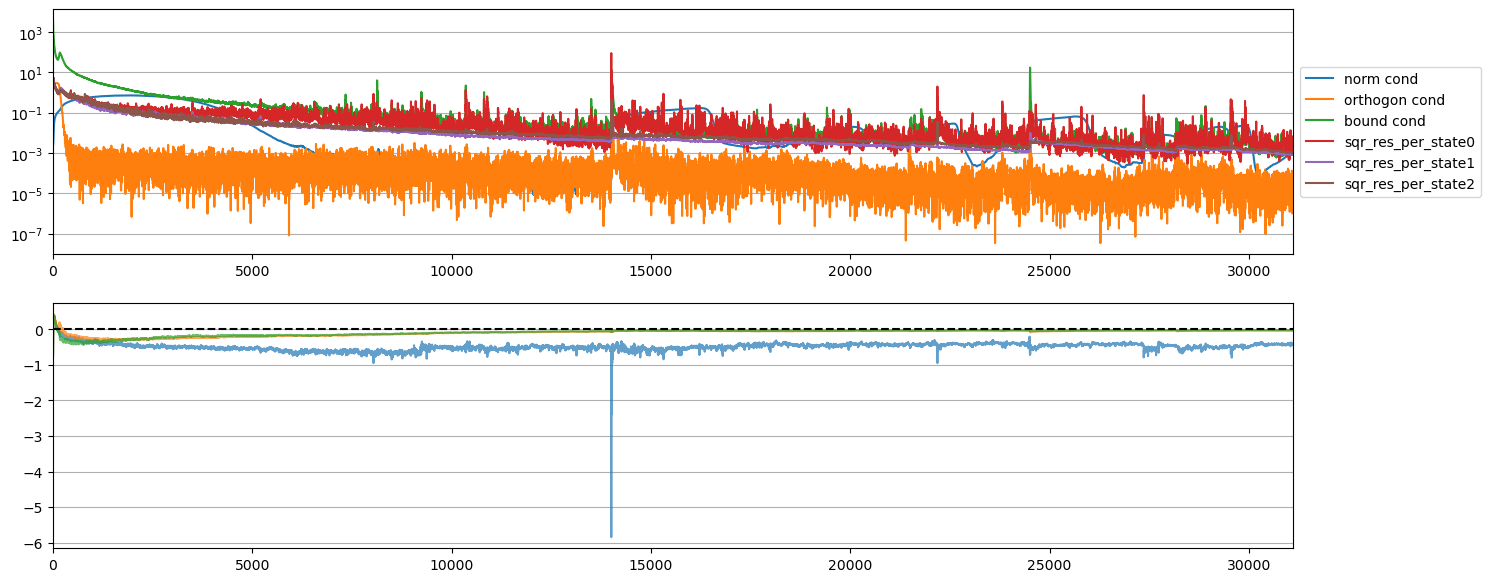

In [54]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

hist = pd.read_csv("history/test_He.csv")
xmax = len(hist)
xmin = 0 #xmax - 1000

fig, ax = plt.subplots(2,1,figsize=(16,7))

hist[['norm cond','orthogon cond','bound cond']][xmin:xmax].plot(xlim=(xmin, xmax), ax = ax[0])
hist[[f"sqr_res_per_state{s}" for s in range(3)]][xmin:xmax].plot(xlim=(xmin, xmax), ax = ax[0])
# ax[0].plot(np.arange(xmin,xmax), np.sum(hist[[f'Rayleigh{i}' for i in range(16)]][xmin:xmax].to_numpy(), axis=1))
ax[0].set_yscale('log')
ax[0].grid(axis='y')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

hist[[f'Rayleigh{i}' for i in range(3)]][xmin:xmax].plot(xlim=(xmin, xmax), legend=False, ax = ax[1], alpha=0.7)
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].grid(axis='y')
# ax[1].set_yscale('symlog')

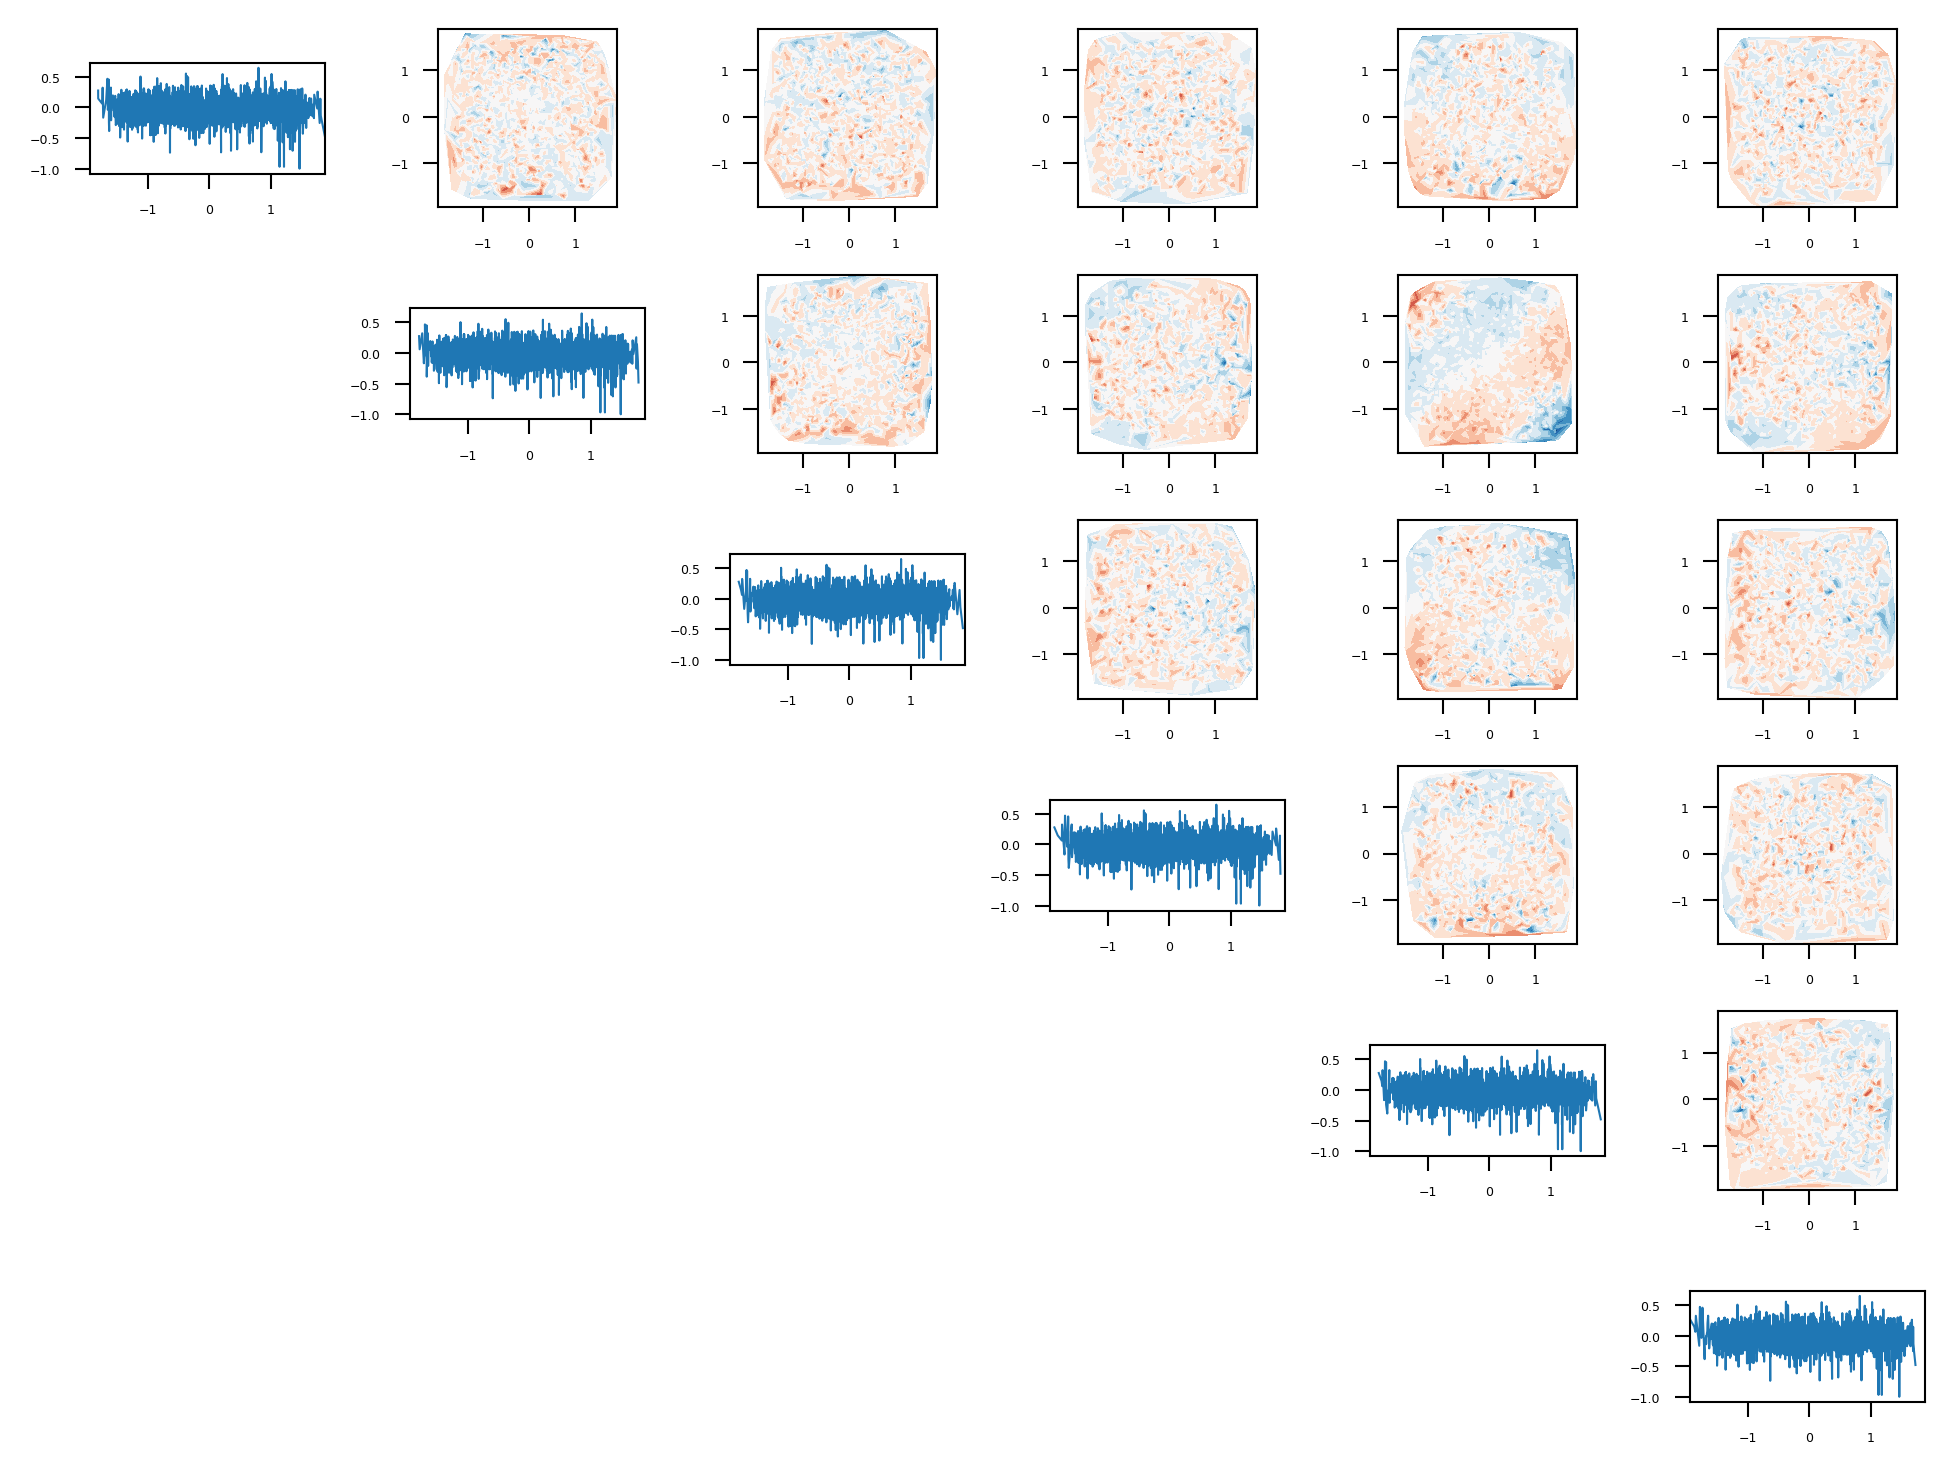

In [68]:
fig0 = show_state(model, 0, 2000)